In [4]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline

import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import warnings
from csv_reader import read_csv
from aux import set_smallest_n_zero
from disp import set_font_size, get_ordered_colors
from copy import deepcopy as copy
from analysis_tools import *
from pathlib import Path
from csv_reader import read_csv
from csv_writer import write_csv
import glob
from scipy import stats

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}

matplotlib.rcParams.update(new_rc_params)

plt.rc('font', family='serif')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 3.0

warnings.filterwarnings('ignore')

rule_names = [ # Define labels for all rules to be run during simulations
    r'Const',
    r'$y$',
    r'$x$',
    r'$x \, y$',
    r'$y_{int}$',
    r'$x \, y_{int}$',
    r'$x_{int}$',
    r'$x_{int} \, y$',
    r'$y_{int} \, y$',
    r'$x_{int} \, x$',

    r'$w$',
    r'$w \, y$',
    r'$w \, x$',
    r'$w \, x \, y$',
    r'$w y_{int}$',
    r'$w x \, y_{int}$',
    r'$w x_{int}$',
    r'$w x_{int} \, y$',
    r'$w y_{int} \, y$',
    r'$w x_{int} \, x$',
]

time_constants = [
    r'$\tau \, y_{int}$',
    r'$\tau \, x \, y_{int}$',
    r'$\tau \, x_{int}$',
    r'$\tau \, x_{int} \, y$',
    r'$\tau \, y_{int} \, y$',
    r'$\tau \, x_{int} \, x$',
    
    r'$\tau \, w y_{int}$',
    r'$\tau \, w x \, y_{int}$',
    r'$\tau \, w x_{int}$',
    r'$\tau \, w x_{int} \, y$',
    r'$\tau \, w y_{int} \, y$',
    r'$\tau \, w x_{int} \, x$',
]

general_rule_names = copy(rule_names)

rule_names = [
    [r'$E \rightarrow E$ ' + r_name for r_name in rule_names],
    [r'$E \rightarrow I$ ' + r_name for r_name in rule_names],
    [r'$I \rightarrow E$ ' + r_name for r_name in rule_names],
]
rule_names = np.array(rule_names).flatten()

In [5]:
def plot_opt_run(file_name, n_plasticity_coefs, n_time_constants, batch_size, start=0, yscale=None, n_categories=1, loss_yscale=None):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    
    df_train = read_csv(train_data_path, read_header=False, start=1)
    df_test = read_csv(test_data_path, read_header=False, start=1)
    
    # plot synaptic effects per rule
    scale = 1.5
    fig, axs = plt.subplots(1, 2, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Rule coefficient')
    if yscale is not None:
        axs[0].set_ylim(0, yscale)
    
    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    x = np.arange(df_train.shape[0])[start:]
    x_test = np.arange(df_test.shape[0])[start:]
    losses = df_train[df_train.columns[1]][start:]
    x_mins = []

    for i in range(0, len(x), 15):
        x_mins.append(np.argmin(losses[i:i+15]) + i)
        
    x_mins = np.array(x_mins)
    x_best_min = np.argmin(losses)
    
    x_test = df_test[df_test.columns[0]]
    losses_test = df_test[df_test.columns[1]]
    
    final_syn_effects = []
    final_coefs = []
    
    for i in range(syn_effect_start, syn_effect_end):
#         axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        
        final_syn_effects.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    final_syn_effects = np.array(final_syn_effects)
        
    axs[1].plot(x_mins[1:-1], losses[x_mins[1:-1]], color='black')
    axs[1].plot(x_test, losses_test, color='blue')
    axs[1].set_ylim(0, 5000)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
        
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants
    
    cmap = matplotlib.cm.get_cmap('nipy_spectral')
    colors = [cmap(x) for x in np.linspace(0, 1, n_plasticity_coefs + n_time_constants)]
    np.random.shuffle(colors)
    
    for i in range(plasticity_coefs_start, plasticity_coefs_end):
        axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins], color=colors[i - plasticity_coefs_start])
        final_coefs.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    set_font_size(axs[0], 20)
    set_font_size(axs[1], 20)
    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.png'))
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.svg'))
    
    final_coefs = np.array(final_coefs)
    
    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    
    partial_rules_len = int(len(final_syn_effects) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effects[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_coefs[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
#         y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        axs[l].bar(x, y, color=colors, alpha=0.3)
        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)    
    
        set_font_size(axs[l], 20)
        

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))
    
    # plot entropy of synaptic change per rule against epochs
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Entropy')
    
    entropy = []
    for i in x_mins[1:]:
        syn_effects_i = np.array(df_train.iloc[i][syn_effect_start:syn_effect_end])
        entropy.append(calc_entropy(syn_effects_i))
        
    entropy = np.array(entropy)
    
    axs.plot(x_mins[1:], entropy, c='green')
    
    scale = 2
    fig2, axs2 = plt.subplots(1, 1, figsize=(2.5 * scale, 6 * scale))
#     format_axs(axs2)

    x = np.concatenate([np.arange(n_plasticity_coefs), np.arange(n_plasticity_coefs + 1, n_plasticity_coefs + 1 + n_time_constants)])
    y = np.array(final_coefs)
    axs2.barh(x, y, alpha=0.5, color=['#1128d4'] * n_plasticity_coefs + ['#6528de'] * n_time_constants)
#     axs2.errorbar(x, y, yerr=final_plasticity_coef_stds, ls='none', color='black')
    
    axs2.set_ylim(len(x) + 1, -1)
    axs2.set_yticks(np.arange(len(x) + 1))
    tick_labels = list(general_rule_names[:len(x)]) + [''] + time_constants
    axs2.set_yticklabels(tick_labels, rotation=0)
    axs2.set_xlabel('Duration (s)')
    axs2_twin = axs2.twiny()
    axs2_twin.set_xlabel('Coefficient')
    
    axs2.spines['right'].set_visible(False)
    axs2_twin.spines['right'].set_visible(False)
    
    x_lim = np.max(np.abs(y)) * 1.02
    
    axs2.set_xlim(-x_lim, x_lim)
    plt.locator_params(axis='x', nbins=3)
    axs2_twin.set_xlim(-x_lim, x_lim)
    plt.locator_params(axis='x', nbins=3)
    
    set_font_size(axs2, 20)
    set_font_size(axs2_twin, 20)

    return np.array(final_syn_effects), np.array(final_coefs), losses[x_best_min]

In [6]:
def plot_all_opt_runs(all_files, n_plasticity_coefs, n_time_constants, batch_size, n_categories=3, l_thresh=1000, name='default'):
    figure_path = f'./figures/{name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    final_syn_effects = []
    final_plasticity_coefs = []

    for f in all_files:
        syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_opt_run(f, n_plasticity_coefs, n_time_constants, batch_size, n_categories=n_categories)
        if best_loss_for_f < l_thresh:
            print(f'{f}')
            final_syn_effects.append(syn_effects_for_f)
            final_plasticity_coefs.append(plasticity_coefs_for_f)

    final_syn_effects = np.stack(final_syn_effects)
    final_syn_effect_means = np.mean(final_syn_effects, axis=0)
    final_syn_effect_stds = np.std(final_syn_effects, axis=0) / np.sqrt(final_syn_effects.shape[0])

    final_plasticity_coefs = np.stack(final_plasticity_coefs)
    final_plasticity_coef_means = np.mean(final_plasticity_coefs, axis=0)
    final_plasticity_coef_stds = np.std(final_plasticity_coefs, axis=0) / np.sqrt(final_plasticity_coefs.shape[0])

    print(final_plasticity_coef_means)

    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    partial_rules_len = int(len(final_syn_effect_means) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
        y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
        axs[l].bar(x, y, alpha=0.3, color=colors)
        axs[l].errorbar(x, y, yerr=y_err, ls='none', color='black')

        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)
        
        set_font_size(axs[l], 20)

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))

    # plot the synaptic effects of each plasticity rule as scatter plot
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 2 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]

    cmap = matplotlib.cm.get_cmap('nipy_spectral')
    colors = [cmap(x) for x in np.linspace(0, 0.55, final_syn_effects.shape[1])]
    np.random.shuffle(colors)

    max_val = 0
    for i in range(n_categories):
        for j in range(partial_rules_len):
            x = i * partial_rules_len + j
            y = final_syn_effects[:, x]
            axs[i].scatter(j * np.ones(final_syn_effects.shape[0]) + np.random.normal(0, 0.15, final_syn_effects.shape[0]), y, s=30, facecolors='none', edgecolors=colors[j], marker='o')

            if np.max(y) > max_val:
                max_val = np.max(y)
        axs[i].set_xlim(-1, partial_rules_len)
        if i < n_categories - 1:
            axs[i].set_xticks([])

    axs[-1].set_xticklabels(general_rule_names, rotation=60)
    axs[-1].set_xticks(np.arange(partial_rules_len))

    axs[0].set_ylabel('Absolute synaptic change')

    for i in range(n_categories):
        axs[i].set_ylim(0, max_val * 1.1)

    # plot covariance of synaptic changes due to each rule
    normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    format_axs(axs)
    syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
    max_abs_val = np.max(np.abs(syn_effect_cov_mat))
    mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    plt.colorbar(mappable)
    axs.set_xticks(np.arange(len(final_syn_effect_means)))
    axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60)
    axs.set_yticks(np.arange(len(final_syn_effect_means)))
    axs.set_yticklabels(rule_names[:len(final_syn_effect_means)], rotation=0)

    # plot the coefficients assigned to each plasticity rule (unsorted by size)
    scale = 2
    fig2, axs2 = plt.subplots(1, 1, figsize=(3 * scale, 6 * scale))
#     format_axs(axs2)

    x_lim = np.max(np.abs(final_plasticity_coefs)) * 1.05

    # draw background lines
    spacing = 10e-3
    for k in range(int(x_lim / spacing) + 1):
        axs2.plot([k * spacing, k * spacing], [-1, n_plasticity_coefs + n_time_constants + 1], '--', color='gray', alpha=0.3)
        if k > 0:
            axs2.plot([-k * spacing, -k * spacing], [-1, n_plasticity_coefs + n_time_constants + 1], '--', color='gray', alpha=0.3)
    
    x_coefs = np.arange(n_plasticity_coefs)
    y_coefs = final_plasticity_coefs[:, :n_plasticity_coefs]
    
    violin_parts = axs2.violinplot(y_coefs, widths=0.75, showmeans=False, showextrema=False, positions=x_coefs, vert=False)
    for pc in violin_parts['bodies']:
        pc.set_color('#1128d4')
        
    x_tcs = np.arange(n_plasticity_coefs + 1, n_plasticity_coefs + 1 + n_time_constants)
    y_tcs = final_plasticity_coefs[:, n_plasticity_coefs:]
    
    violin_parts = axs2.violinplot(y_tcs, widths=0.75, showmeans=False, showextrema=False, positions=x_tcs, vert=False)
    for pc in violin_parts['bodies']:
        pc.set_color('#6528de')
    
    axs2.set_ylim(final_plasticity_coefs.shape[1] + 1, -1)
    x = np.concatenate([x_coefs, x_tcs])
    axs2.set_yticks(x)
    tick_labels = list(general_rule_names[:len(x)]) + time_constants
    axs2.set_yticklabels(tick_labels, rotation=0)
    
#     violin_parts = axs2.violinplot(final_plasticity_coefs, widths=0.75, showmeans=True, showextrema=False, positions=x, vert=False)
#     for pc in violin_parts['bodies']:
#         pc.set_color('grey')

    for r_idx in range(final_plasticity_coefs.shape[0]):
        axs2.scatter(final_plasticity_coefs[r_idx, :], x + np.random.normal(size=len(x), scale=0.05), facecolors='none', edgecolors='black', marker='o', s=20)
#     axs2.errorbar(x, y, yerr=final_plasticity_coef_stds, ls='none', color='black')
    
    axs2.set_xlabel('Duration (s)')
    axs2_twin = axs2.twiny()
    axs2_twin.set_xlabel('Coefficient')
    
#     axs2.spines['right'].set_visible(False)
#     axs2_twin.spines['right'].set_visible(False)
    
    axs2.set_xlim(-x_lim, x_lim)
    axs2.set_xticks([])
    axs2.set_xticklabels([])
    axs2_twin.set_xlim(-x_lim, x_lim)
    
#     set_font_size(axs2, 20)
#     set_font_size(axs2_twin, 20)
    fig2.savefig(os.path.join(figure_path, 'coefs.png'))
    fig2.savefig(os.path.join(figure_path, 'coefs.svg'))
    
    scale = 2
    fig3, axs3 = plt.subplots(1, 1, figsize=(3 * scale, 3 * scale))
    
    effect_sizes = np.abs(final_plasticity_coefs.std(axis=0) / final_plasticity_coefs.mean(axis=0))
    
    print(final_syn_effect_means.shape)
    print(effect_sizes.shape)
    
    axs3.scatter(effect_sizes[:n_plasticity_coefs], np.median(final_syn_effects, axis=0))
    

# Finding a minimal set of plasticity rules that supports self-organization of sequence generation

decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8000_2023-08-29_23:47:23.365282
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8001_2023-08-29_23:48:26.168644
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8002_2023-08-29_23:48:44.153583
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8003_2023-08-29_23:49:09.077896
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8004_2023-09-04_07:15:54.654105
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8005_2023-12-05_17:47:42.563397
decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.0

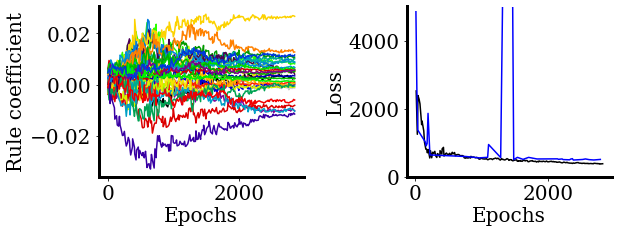

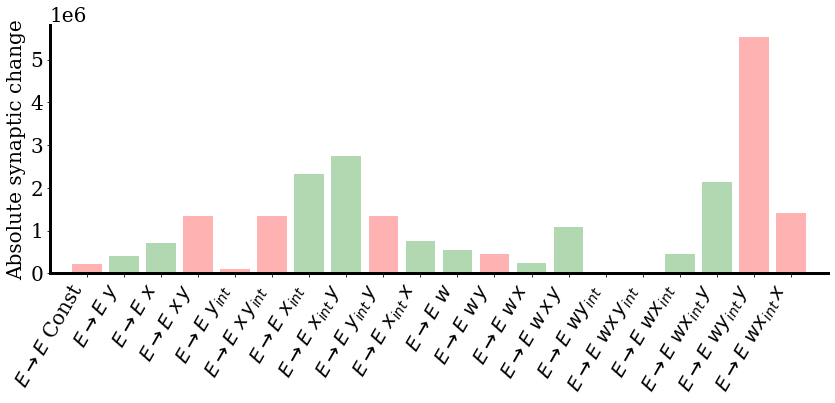

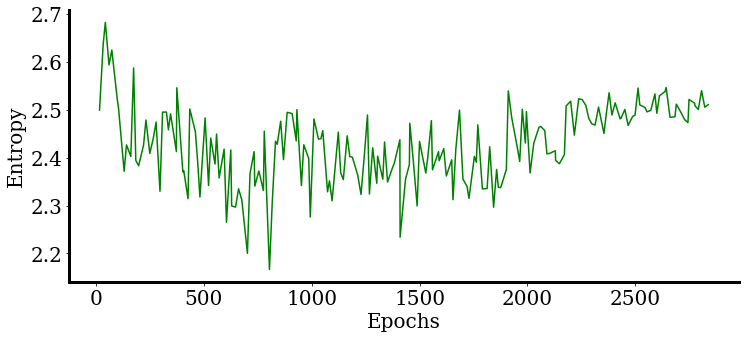

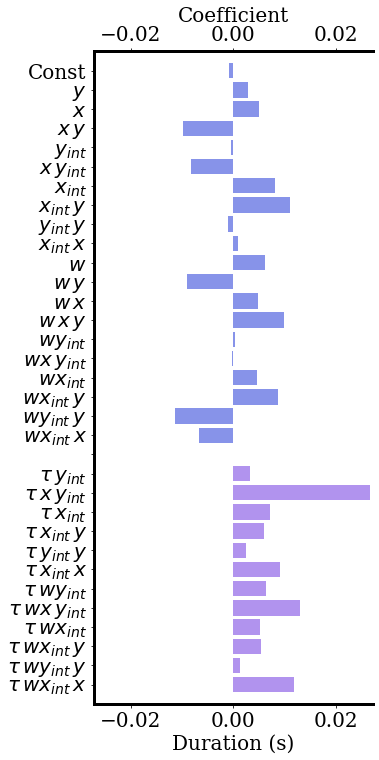

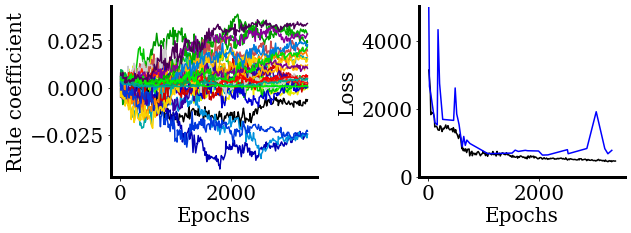

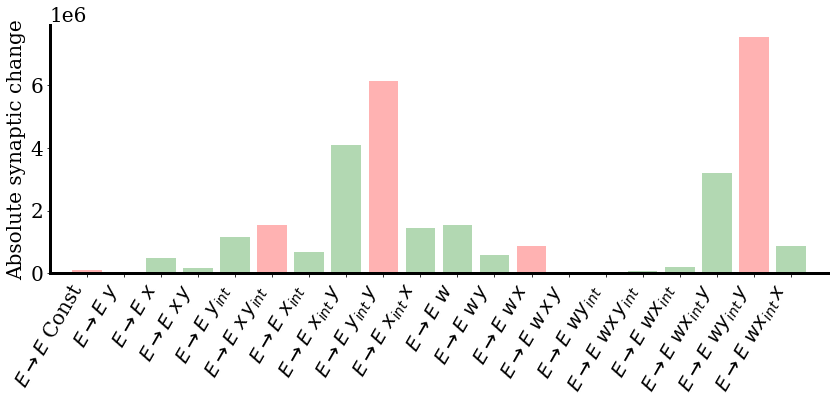

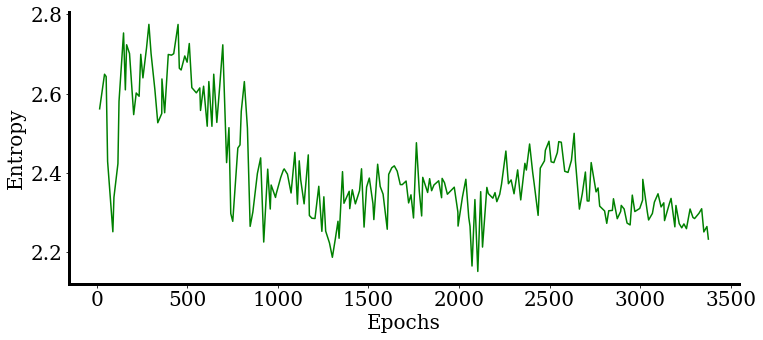

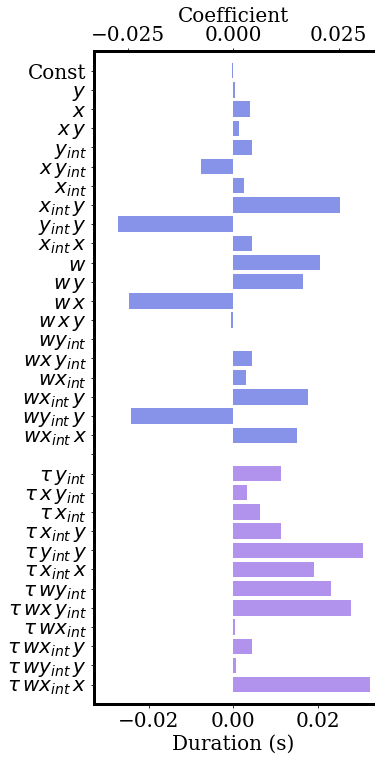

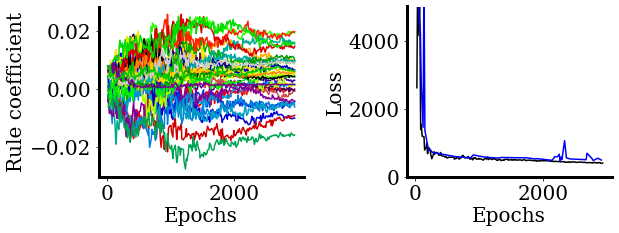

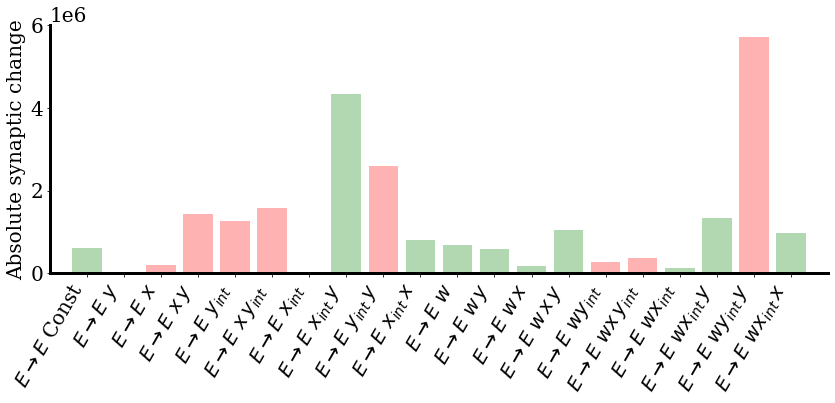

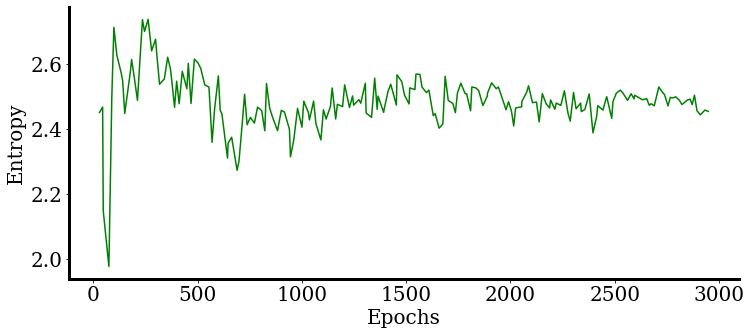

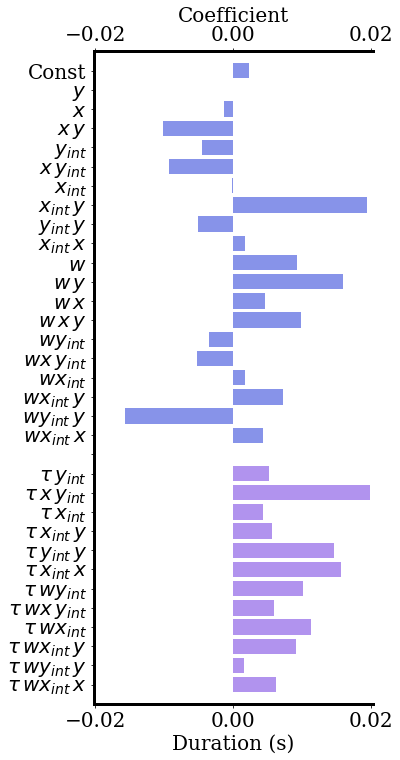

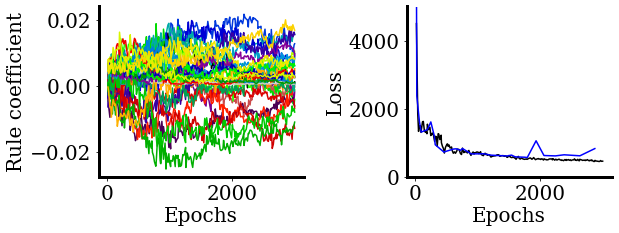

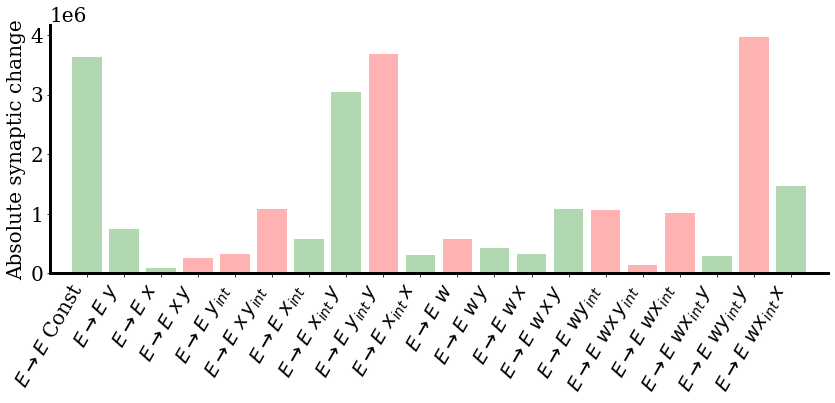

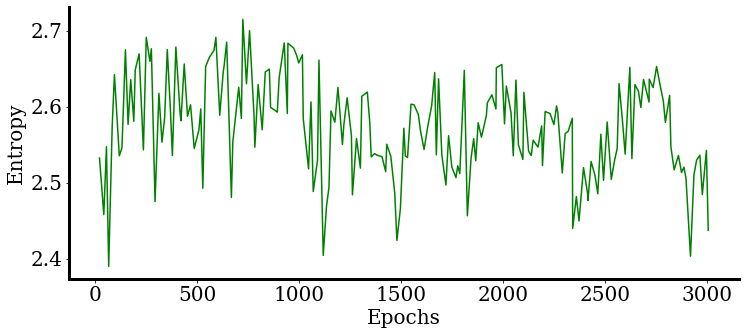

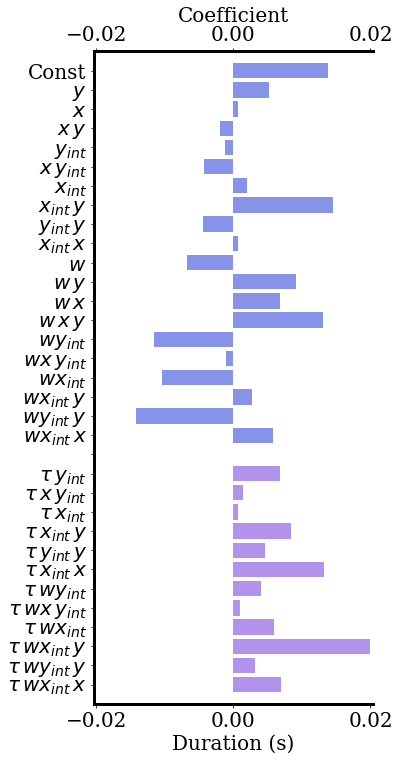

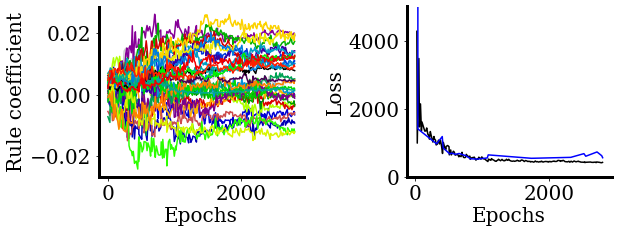

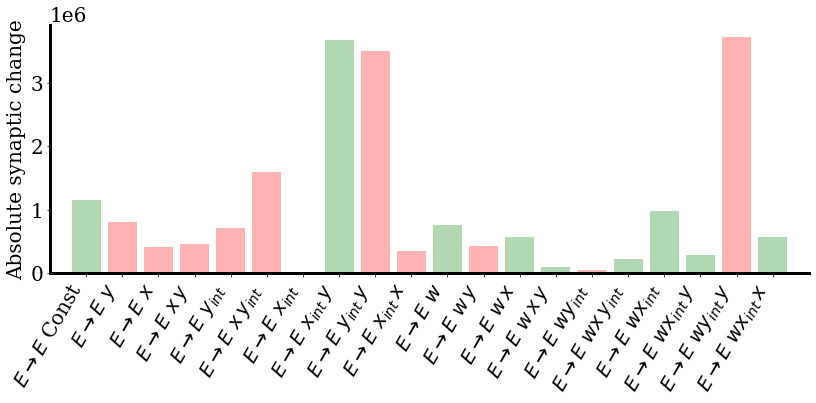

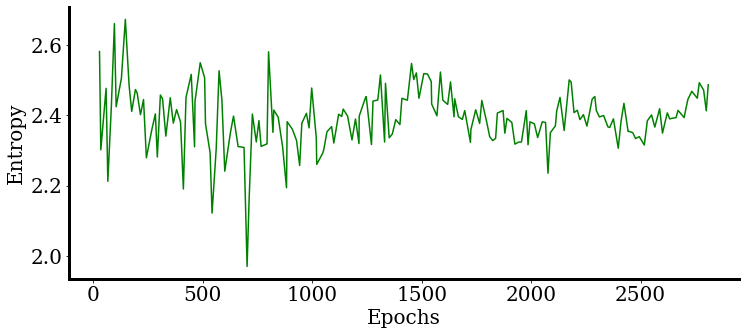

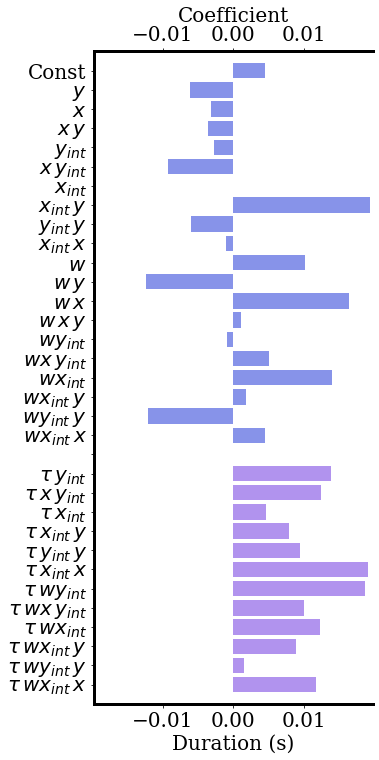

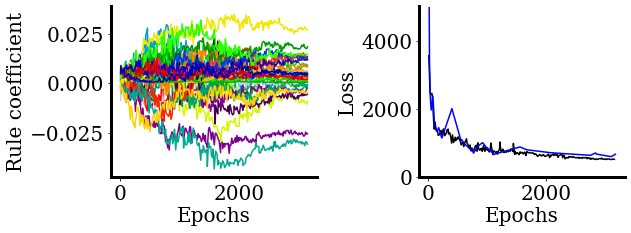

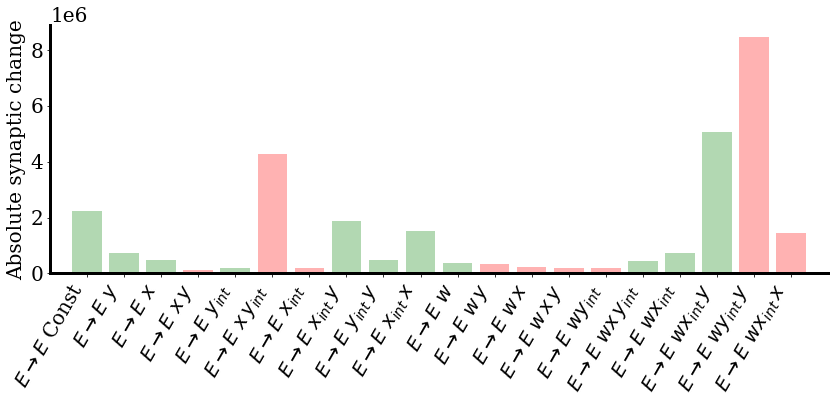

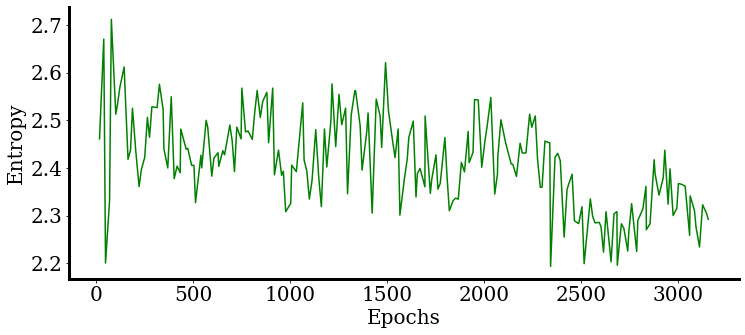

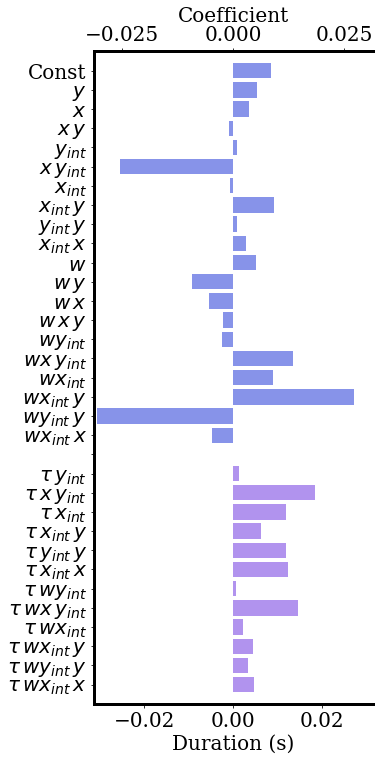

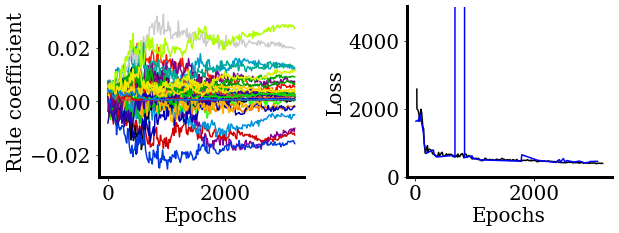

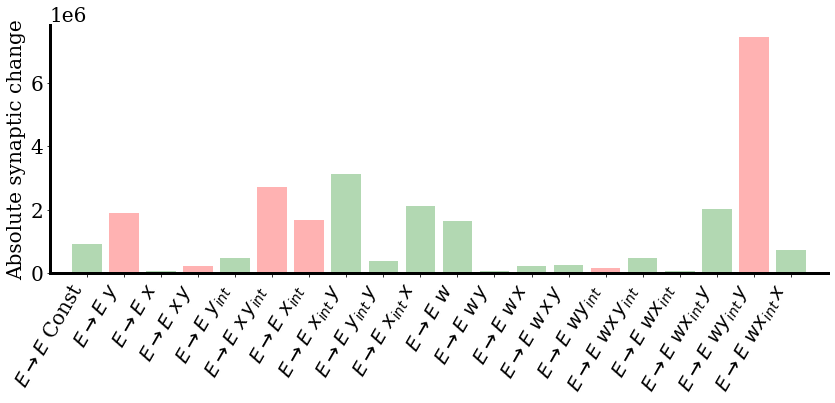

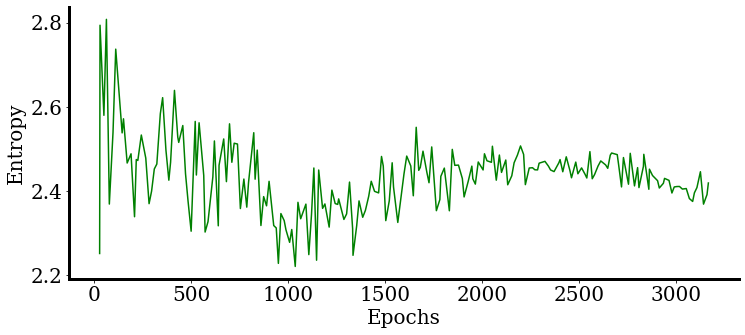

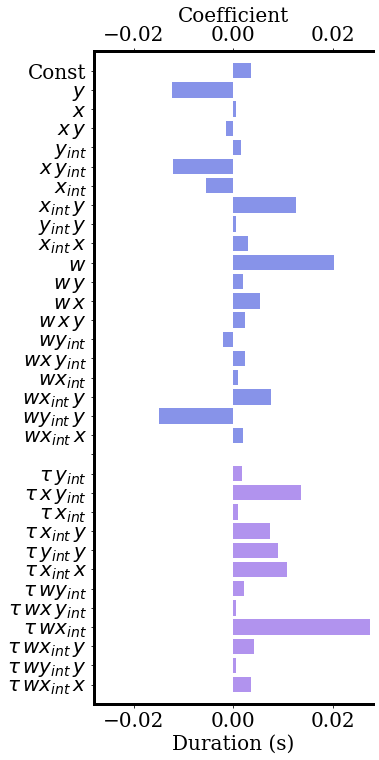

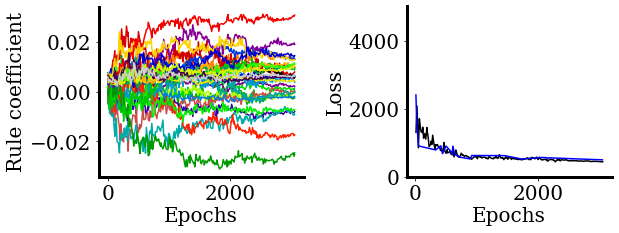

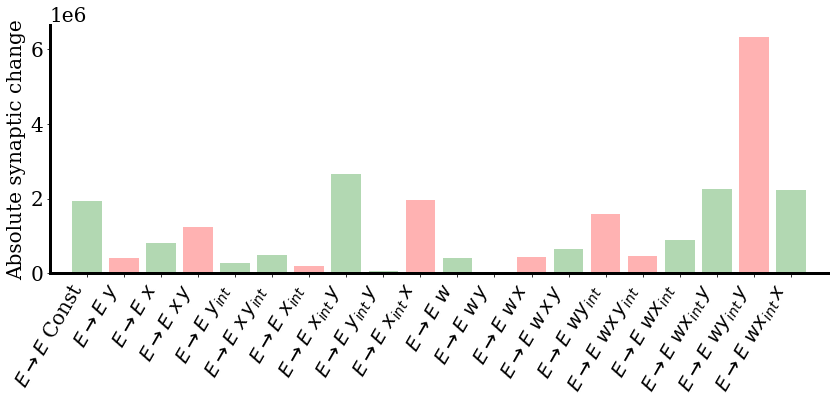

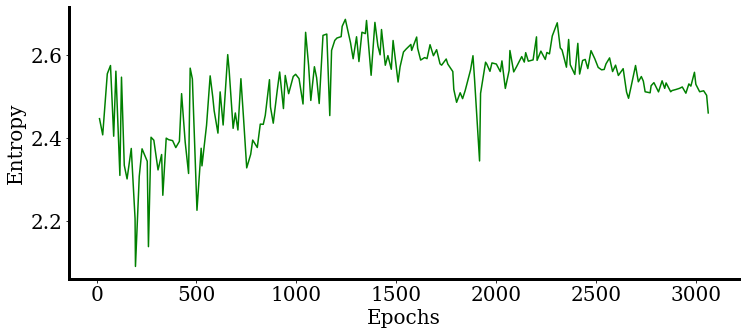

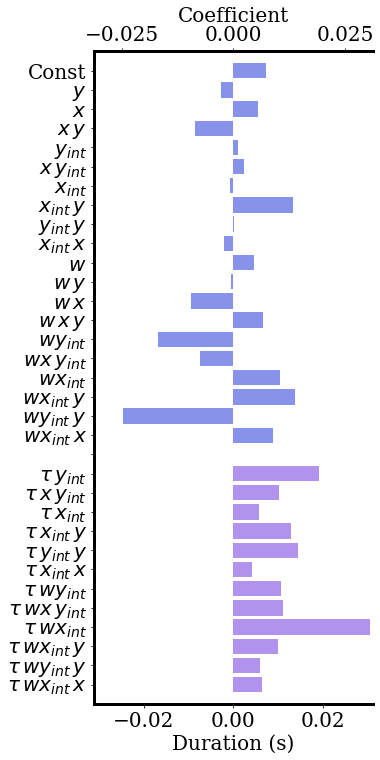

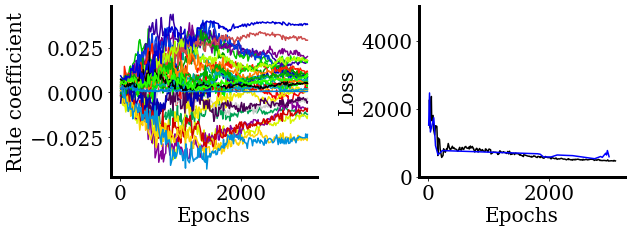

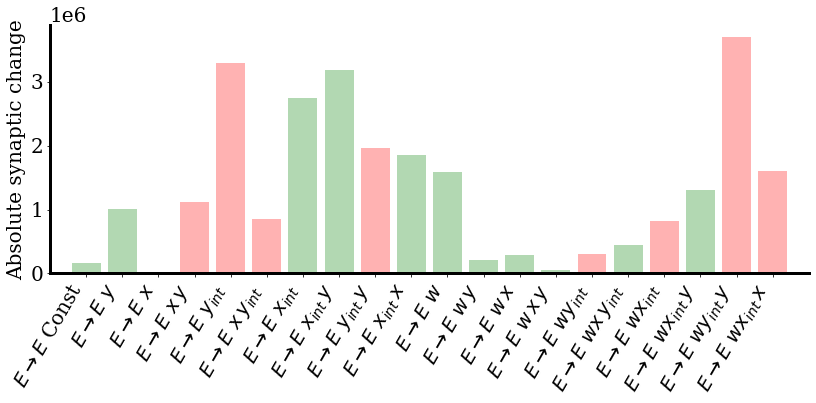

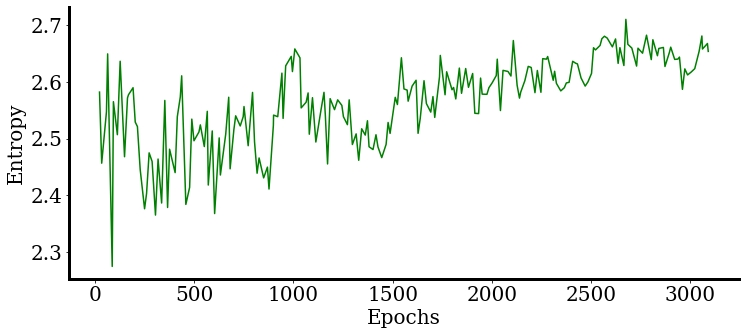

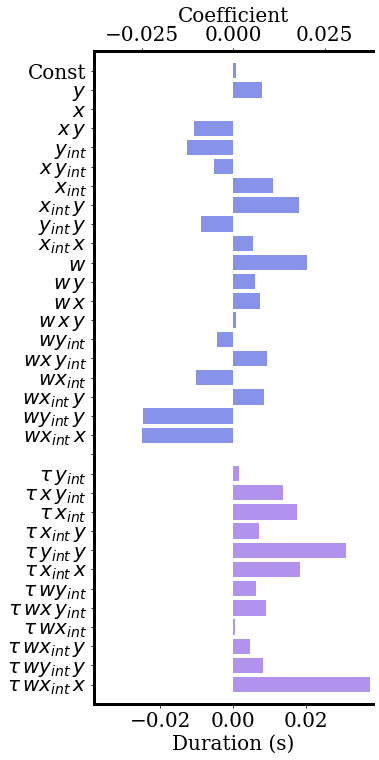

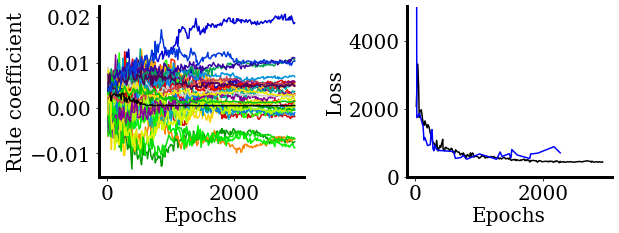

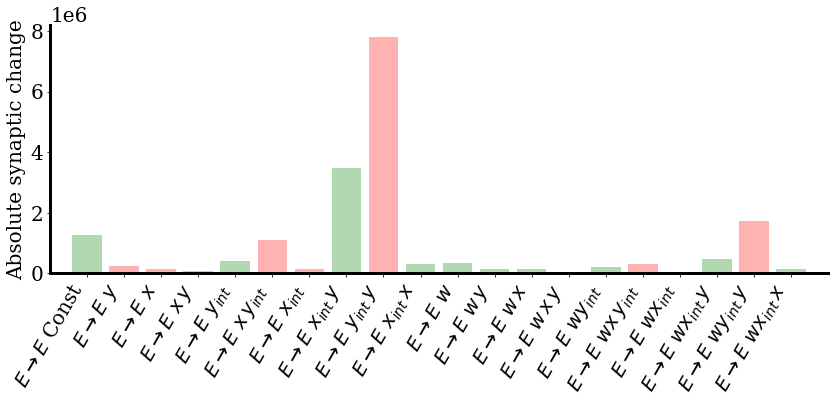

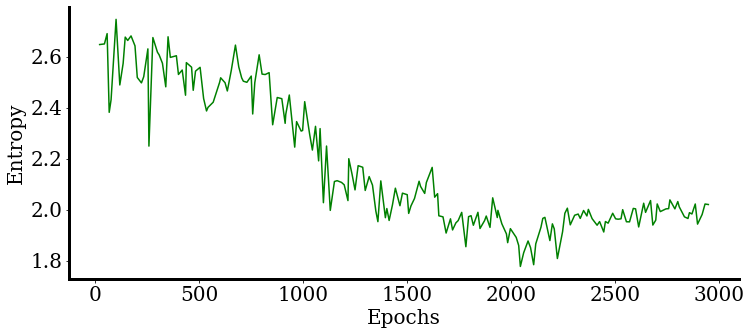

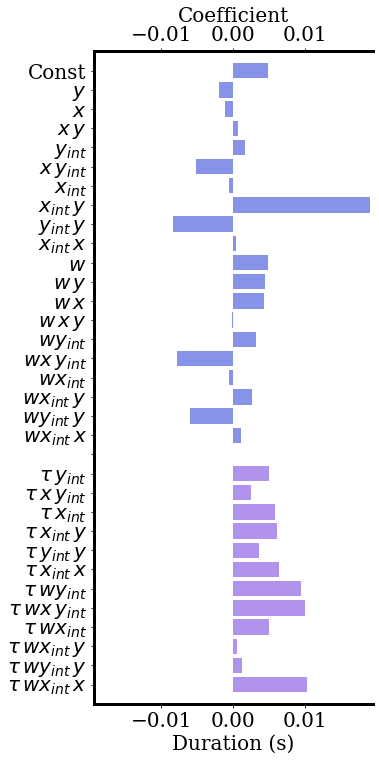

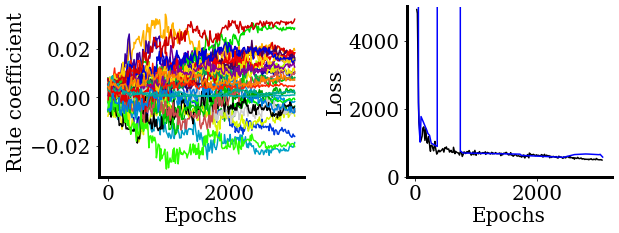

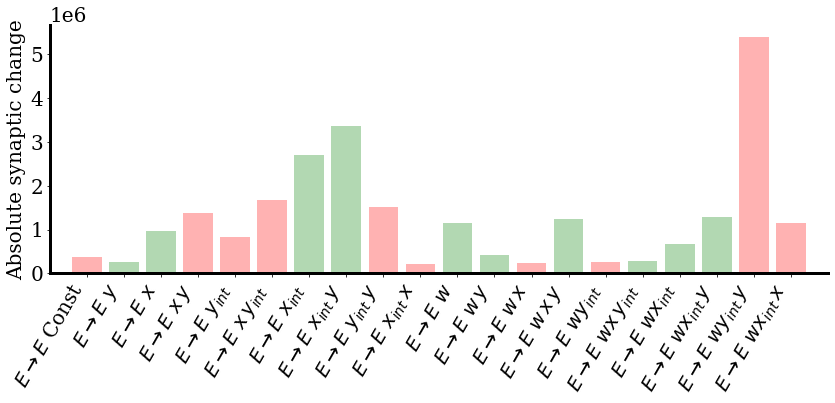

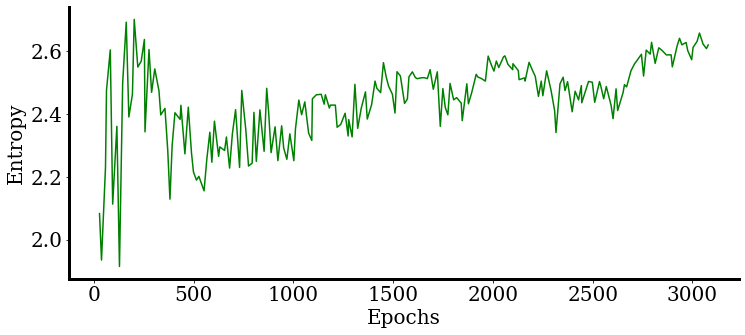

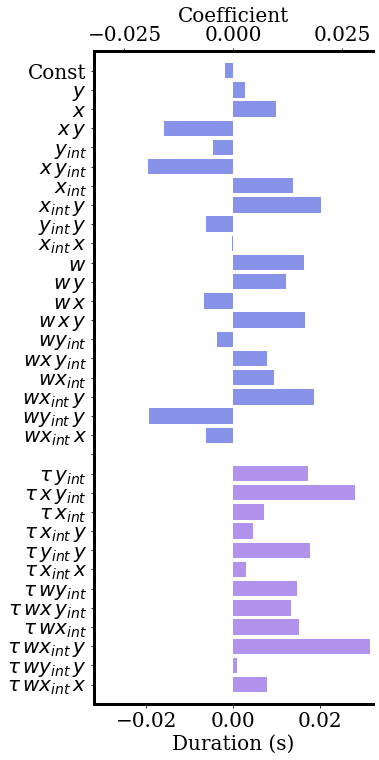

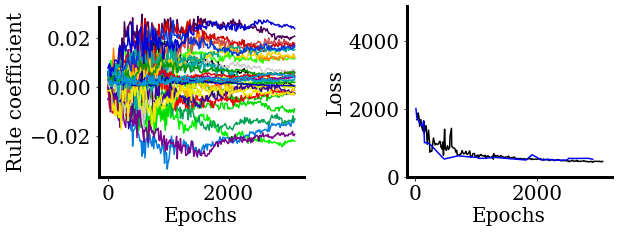

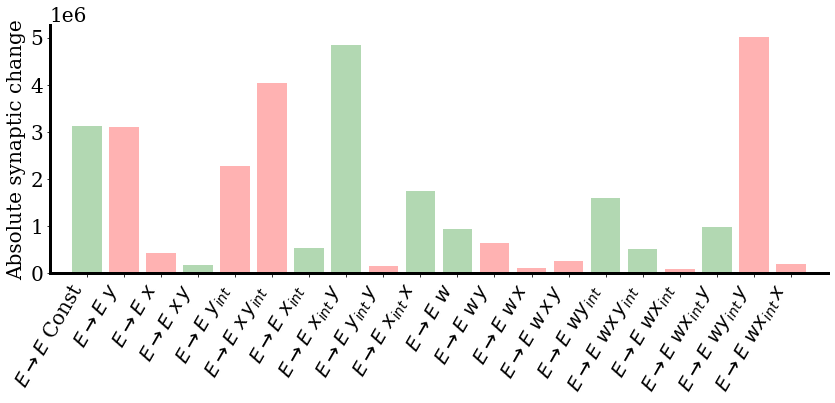

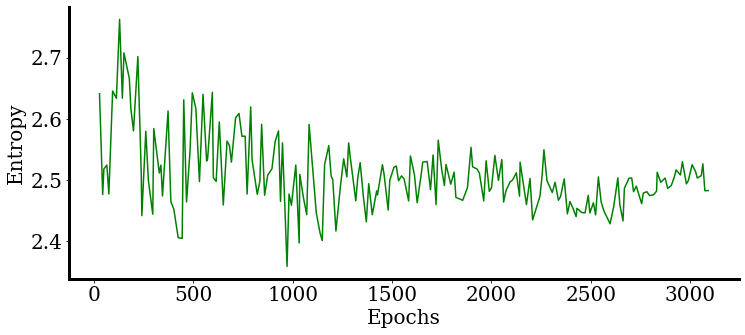

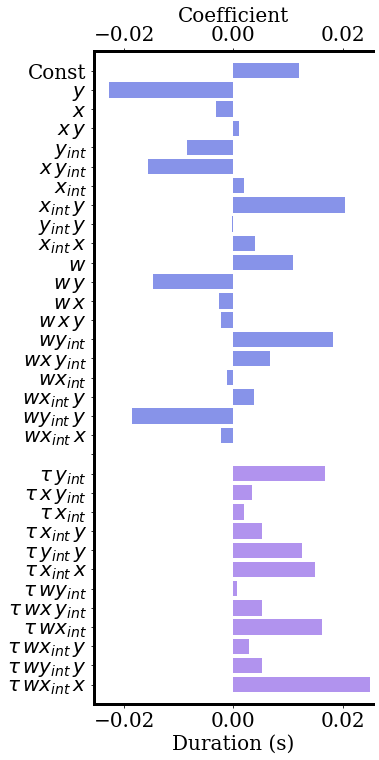

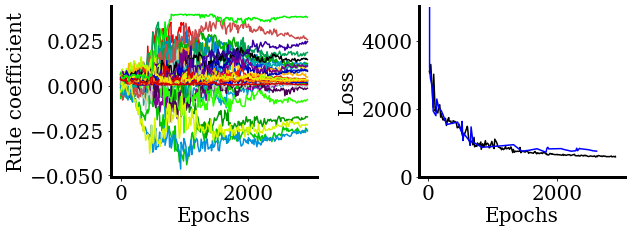

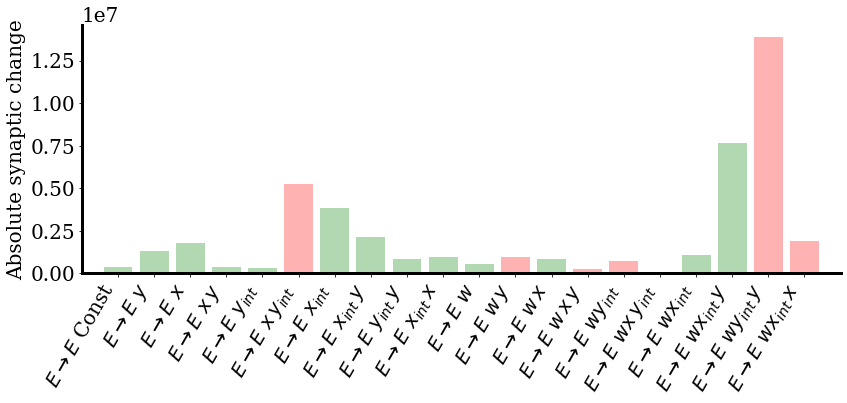

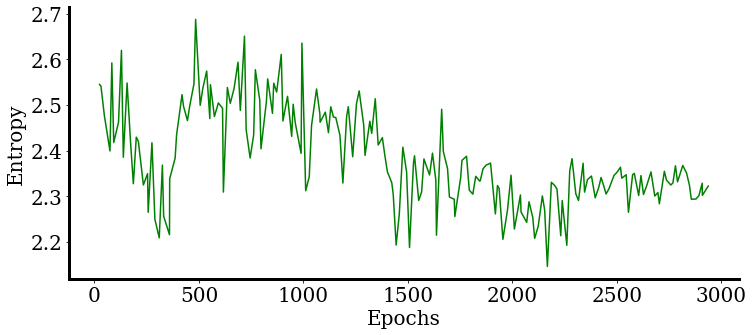

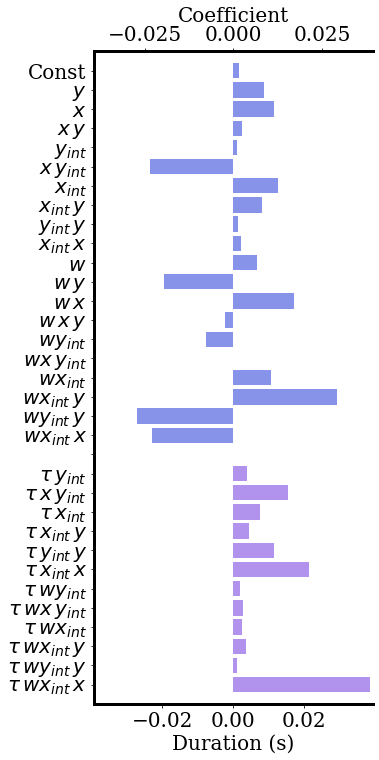

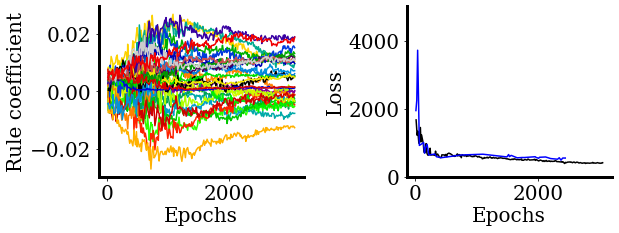

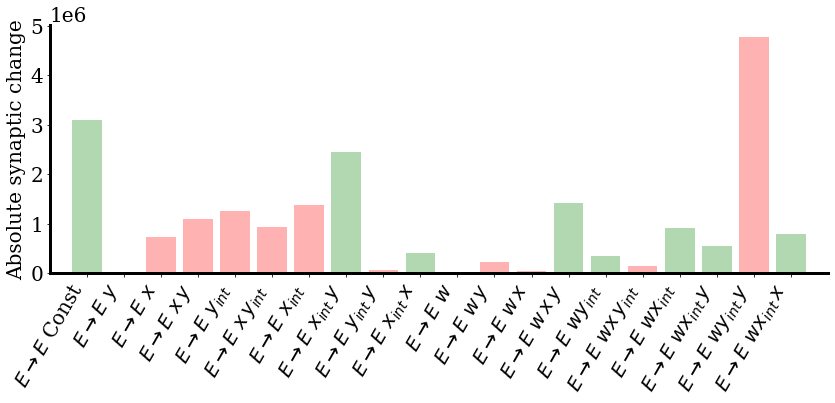

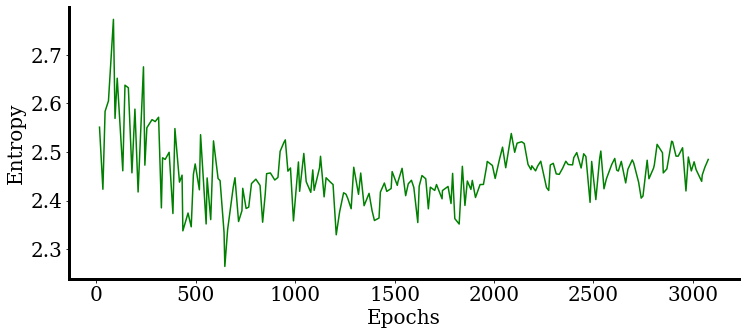

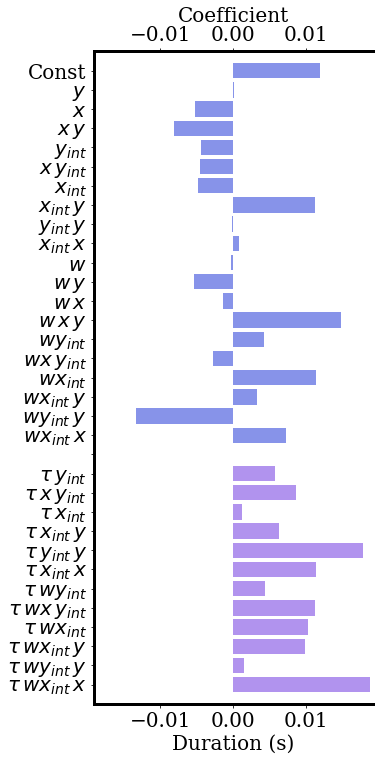

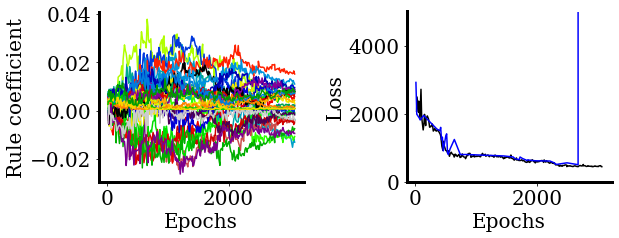

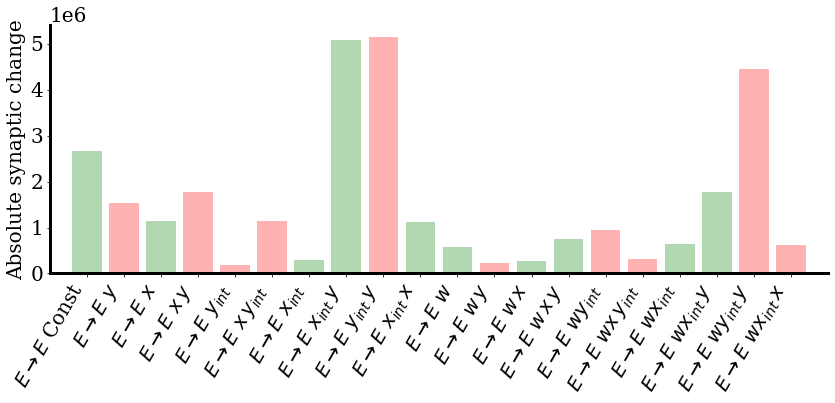

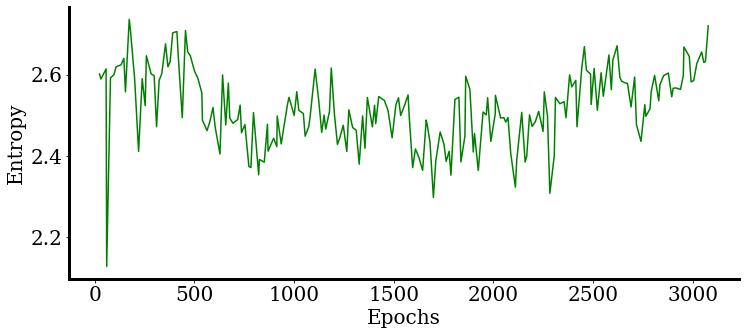

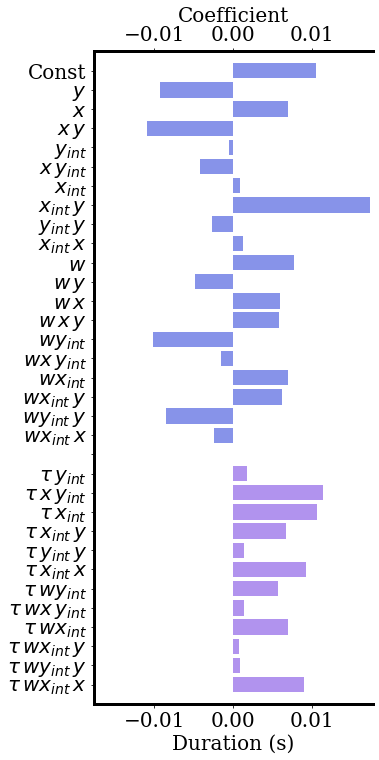

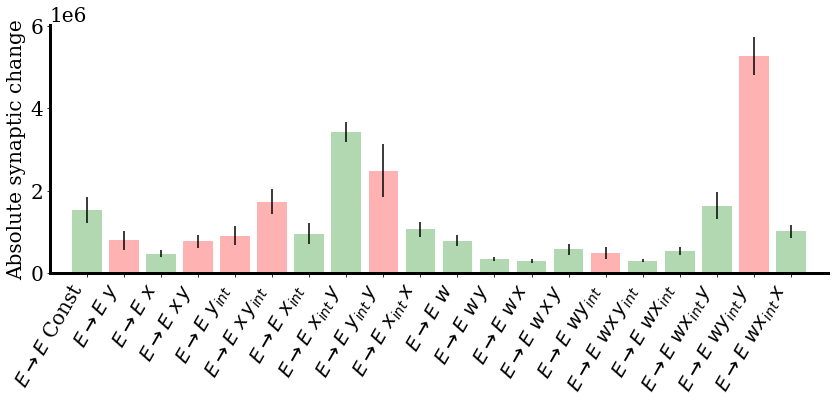

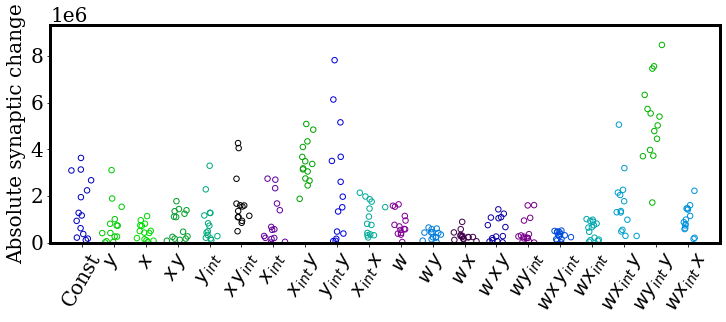

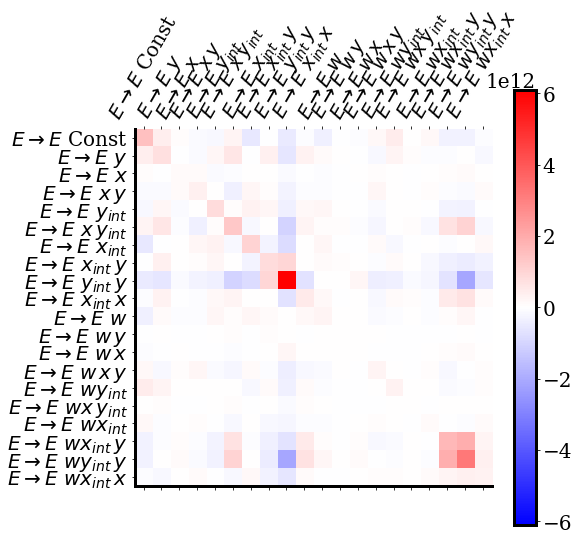

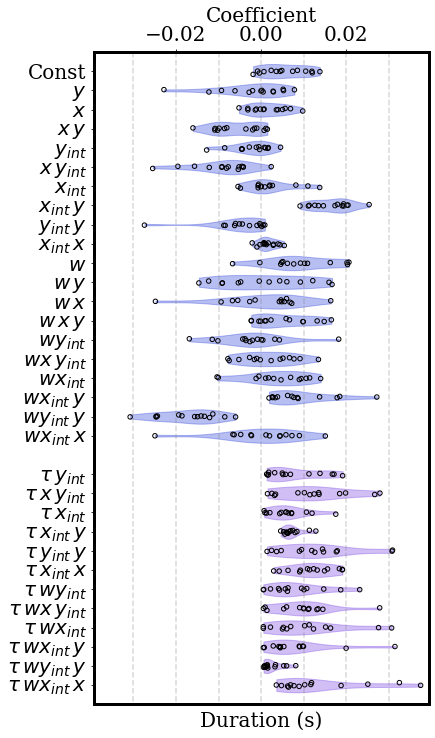

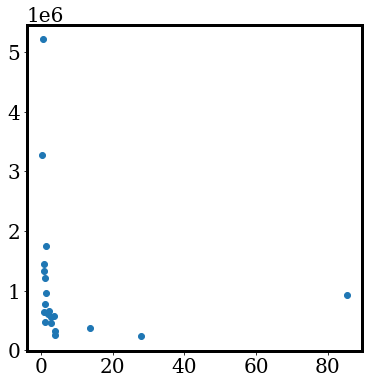

In [21]:
all_files = [
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8000_2023-08-29_23:47:23.365282',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8001_2023-08-29_23:48:26.168644',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8002_2023-08-29_23:48:44.153583',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8003_2023-08-29_23:49:09.077896',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8004_2023-09-04_07:15:54.654105',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8005_2023-12-05_17:47:42.563397',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8006_2023-12-05_19:55:27.149535',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8007_2023-12-05_19:55:27.014616',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8008_2023-12-05_21:35:10.287315',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8009_2023-12-05_21:35:09.973814',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8010_2023-12-05_21:35:10.274776',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8011_2023-12-05_21:35:17.791355',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8012_2023-12-06_04:22:29.292289',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8013_2023-12-06_04:47:17.666729',
    'decoder_ee_rollback_rescaled_b_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8014_2023-12-06_04:47:17.612728',
]

plot_all_opt_runs(all_files, 20, 12, 10, l_thresh=500, n_categories=1, name='ee_unperturbed')

# Evaluating learned rules against a test set and dropping out terms to determine importantance

In [55]:
def load_best_avg_params(file_names, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1):
    for file_name in file_names:
        figure_path = f'./figures/{file_name}'
        Path(figure_path).mkdir(parents=True, exist_ok=True)

        scale = 2
        gs = gridspec.GridSpec(5 * n_categories, 1)
        fig = plt.figure(figsize=(6 * scale, 3 * n_categories * scale), tight_layout=True)
        axs = []
        for i in range(n_categories):
            axs.append([fig.add_subplot(gs[i * 3: i * 3 + 2]), fig.add_subplot(gs[i * 3 + 2:i * 3 + 5])])

        gs_2 = gridspec.GridSpec(5 * n_categories, 1)
        fig_2 = plt.figure(figsize=(6 * scale, 3 * n_categories * scale), tight_layout=True)
        axs_2 = []
        for i in range(n_categories):
            axs_2.append([fig_2.add_subplot(gs_2[i * 3: i * 3 + 2]), fig_2.add_subplot(gs_2[i * 3 + 2:i * 3 + 5])])

        cutoff = 200

        for ax in [axs, axs_2]:
            ax[0][1].set_ylabel('Loss')
            ax[0][0].set_xticks([])
            ax[0][1].set_xticks(np.arange(n_plasticity_coefs + 1))
            ax[0][0].set_xticklabels([])
            ax[0][1].set_xticklabels(np.concatenate([['None'], general_rule_names[:n_plasticity_coefs]]), rotation=60, ha='right')

            ax[0][0].set_yscale('log')
            ax[0][0].set_ylim(cutoff * 0.5, 1e9)
            ax[0][1].set_ylim(0, cutoff * 1.1)
            ax[0][0].set_xlim(-1, n_plasticity_coefs + 1)
            ax[0][1].set_xlim(-1, n_plasticity_coefs + 1)

            ax[0][0].spines['bottom'].set_visible(False)
#             ax[0][0].spines['right'].set_visible(False)
            ax[0][1].spines['top'].set_visible(False)
#             ax[0][1].spines['right'].set_visible(False)


        train_data_path = f'./sims_out/{file_name}/train_data.csv'
        df_train = read_csv(train_data_path, read_header=False, start=1)

        syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
        syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
        plasticity_coefs_start = 2 + batch_size
        plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

        losses = df_train[df_train.columns[1]]

        all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
        mean_losses_for_dropouts = np.array([np.mean(ls) for ls in all_losses_for_dropouts])
        std_losses_for_dropouts = np.array([np.std(ls) for ls in all_losses_for_dropouts])
        cis_for_dropouts = 1.96 * (std_losses_for_dropouts / np.sqrt(runs))

        sig_diff = np.where(mean_losses_for_dropouts - cis_for_dropouts > mean_losses_for_dropouts[0] + cis_for_dropouts[0], True, False)

        means_under_cutoff = mean_losses_for_dropouts < cutoff

        for i in range(0, (n_plasticity_coefs + 1) * runs, runs):
            idx = int(i/runs)
            losses_for_dropout = losses[i:i + runs]

            color = 'red' if sig_diff[idx] else 'black'


            under_cutoff = losses_for_dropout < cutoff
            axs[0][0].scatter((np.ones(runs) * idx + np.random.normal(size=runs, scale=0.15))[~under_cutoff],
                        losses_for_dropout[~under_cutoff], marker='o', facecolor='none', edgecolor=color)
            axs[0][1].scatter((np.ones(runs) * idx + np.random.normal(size=runs, scale=0.15))[under_cutoff],
                        losses_for_dropout[under_cutoff], marker='o', facecolor='none', edgecolor=color)


            if not means_under_cutoff[idx]:
                axs_2[0][0].errorbar([idx],
                            mean_losses_for_dropouts[idx],
                            yerr=cis_for_dropouts[idx], color=color, capsize=4, linestyle='')
                axs_2[0][0].scatter([idx],
                            mean_losses_for_dropouts[idx], color=color)
            else:
                axs_2[0][1].errorbar([idx], 
                            mean_losses_for_dropouts[idx],
                            yerr=cis_for_dropouts[idx], color=color, capsize=4, linestyle='')
                axs_2[0][1].scatter([idx],
                            mean_losses_for_dropouts[idx], color=color)

#         set_font_size(axs[0][0], 20)
#         set_font_size(axs[0][1], 20)
        fig.savefig(os.path.join(figure_path, 'rule_perturbation.png'))
        fig.savefig(os.path.join(figure_path, 'rule_perturbation.svg'))
        

In [60]:
def loss_violin_plots(file_names, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1, downsample_ratio=1):
    plt.rcParams['axes.linewidth'] = 3.0
    
    for file_name in file_names:
        figure_path = f'./figures/{file_name}'
        Path(figure_path).mkdir(parents=True, exist_ok=True)

        scale = 1.75
        gs = gridspec.GridSpec(7 * n_categories, 1)
        fig = plt.figure(figsize=(7 * scale, 2 * n_categories * scale), tight_layout=True)
        axs = []
        for i in range(n_categories):
            axs.append([fig.add_subplot(gs[i * 7: i * 7 + 2]), fig.add_subplot(gs[i * 7 + 2:i * 7 + 7])])

        cutoff = 400

        for ax in [axs]:
            ax[0][1].set_ylabel('Loss')
            ax[0][0].set_xticks([])
            ax[0][1].set_xticks(np.arange(n_plasticity_coefs + 1))
            ax[0][0].set_xticklabels([])
            ax[0][1].set_xticklabels(np.concatenate([['None'], general_rule_names[:n_plasticity_coefs]]), rotation=60, ha='right')

            ax[0][0].set_yscale('log')
            ax[0][0].set_ylim(cutoff * 0.5, 5e8)
            ax[0][0].set_yticks([1e3, 1e6, 1e9])
            ax[0][1].set_ylim(0, cutoff * 1.1)
            ax[0][0].set_xlim(-1, n_plasticity_coefs + 1)
            ax[0][1].set_xlim(-1, n_plasticity_coefs + 1)

#             ax[0][0].spines['bottom'].set_visible(False)
#             ax[0][0].spines['right'].set_visible(False)
#             ax[0][1].spines['top'].set_visible(False)
#             ax[0][1].spines['right'].set_visible(False)


        train_data_path = f'./sims_out/{file_name}/train_data.csv'
        df_train = read_csv(train_data_path, read_header=False, start=1)

        syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
        syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
        plasticity_coefs_start = 2 + batch_size
        plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

        losses = df_train[df_train.columns[1]]

        all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
        mean_losses_for_dropouts = np.array([np.mean(ls) for ls in all_losses_for_dropouts])
        std_losses_for_dropouts = np.array([np.std(ls) for ls in all_losses_for_dropouts])
        
        p_vals = []
        for k in range(0, n_plasticity_coefs + 1):
            res = stats.ttest_ind(all_losses_for_dropouts[k], all_losses_for_dropouts[0], equal_var=False)
            p_vals.append(res.pvalue)
        
#         axs[0][1].violinplot(np.log(all_losses_for_dropouts.T), widths=0.75, showmeans=True, showextrema=False, positions=np.arange(all_losses_for_dropouts.shape[0]))
    
#         sig_diff = np.where(mean_losses_for_dropouts - cis_for_dropouts > mean_losses_for_dropouts[0] + cis_for_dropouts[0], True, False)

#         means_under_cutoff = mean_losses_for_dropouts < cutoff

        for i in range(0, (n_plasticity_coefs + 1) * runs, runs):
            idx = int(i/runs)
            losses_for_dropout = losses[i:i + runs]
            color = 'red' if p_vals[idx] < (0.05 / n_plasticity_coefs) else 'black'
                
            to_show_mask = np.zeros(runs).astype(bool)
            n_to_show = int(downsample_ratio * runs)
            to_show_mask[:n_to_show] = True
            
            losses_for_dropout_shown = losses_for_dropout[to_show_mask]
            under_cutoff_shown = losses_for_dropout_shown < cutoff
            under_cutoff = losses_for_dropout < cutoff
            losses_over_cutoff = losses_for_dropout[~under_cutoff]
            losses_under_cutoff = losses_for_dropout[under_cutoff]
            losses_over_cutoff_shown = losses_for_dropout_shown[~under_cutoff_shown]
            losses_under_cutoff_shown = losses_for_dropout_shown[under_cutoff_shown]
            
#             if len(losses_over_cutoff) > 0:
#                 violin_parts = axs[0][0].violinplot(losses_over_cutoff, widths=0.75, showmeans=False, showextrema=False, positions=[idx])
#                 for pc in violin_parts['bodies']:
#                     pc.set_color(color)
            
            if len(losses_under_cutoff) > 0:
                violin_parts = axs[0][1].violinplot(losses_under_cutoff, widths=0.75, showmeans=False, showextrema=False, positions=[idx])
                for pc in violin_parts['bodies']:
                    pc.set_color(color)
    
    
            axs[0][0].scatter((np.ones(len(losses_over_cutoff_shown)) * idx + np.random.normal(size=len(losses_over_cutoff_shown), scale=0.15)),
                        losses_over_cutoff_shown, marker='o', facecolor='none', edgecolor=color)
            axs[0][1].scatter((np.ones(len(losses_under_cutoff_shown)) * idx + np.random.normal(size=len(losses_under_cutoff_shown), scale=0.15)),
                        losses_under_cutoff_shown, marker='o', facecolor='none', edgecolor=color)
            

#         set_font_size(axs[0][0], 20)
#         set_font_size(axs[0][1], 20)
        axs[0][1].set_xlabel('Dropped term')

        fig.savefig(os.path.join(figure_path, 'rule_perturbation.png'))
        fig.savefig(os.path.join(figure_path, 'rule_perturbation.svg'))

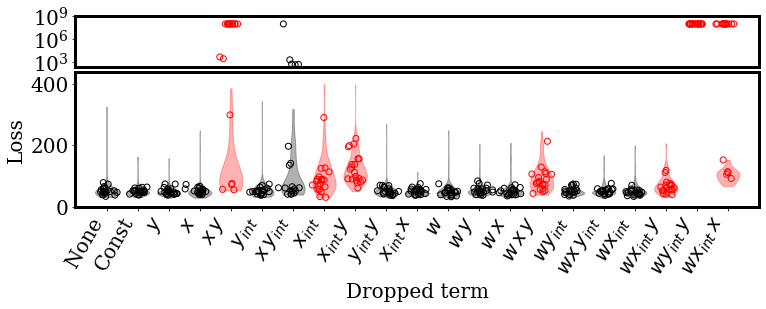

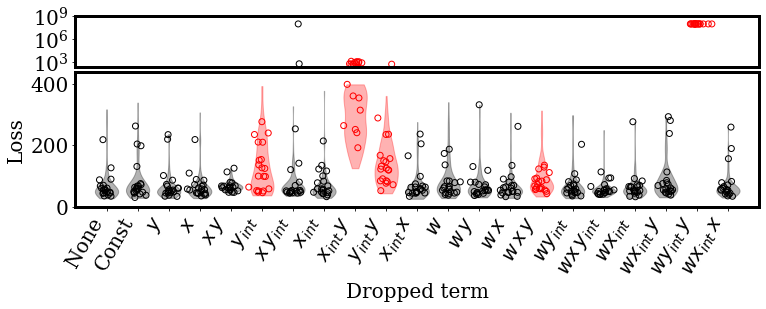

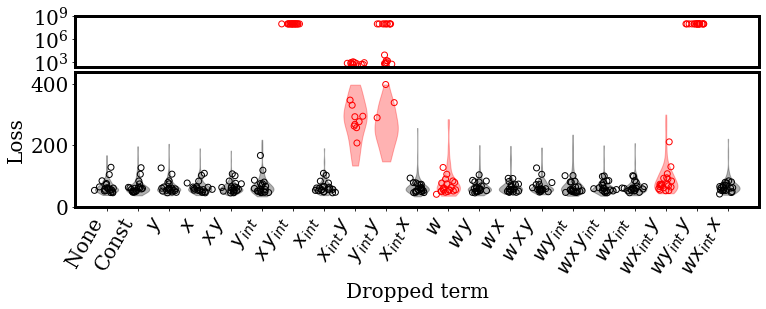

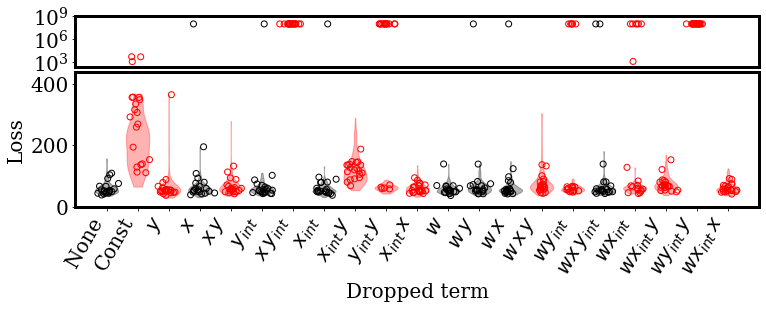

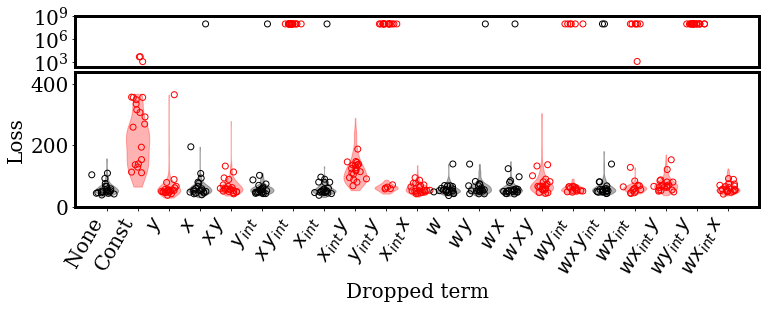

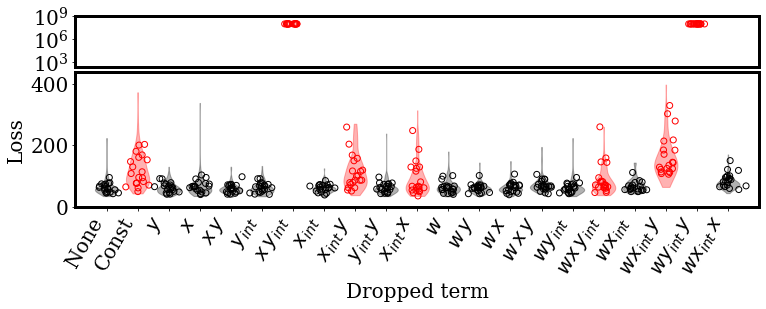

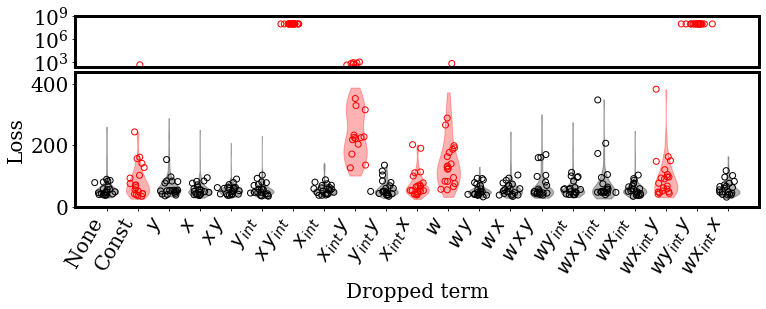

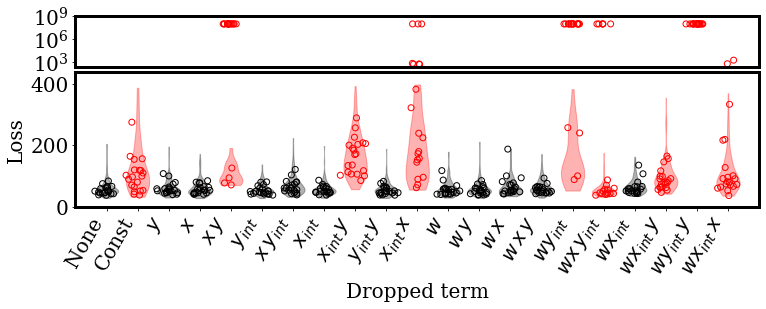

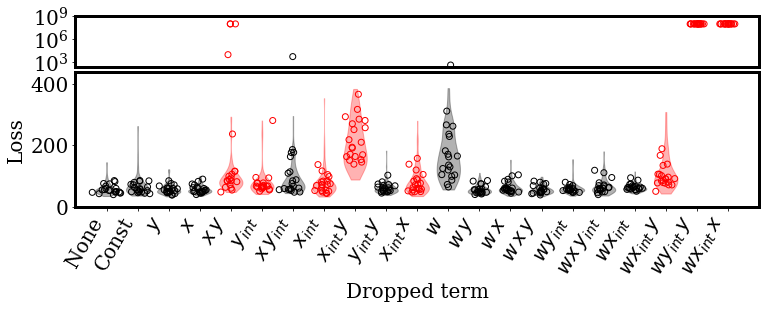

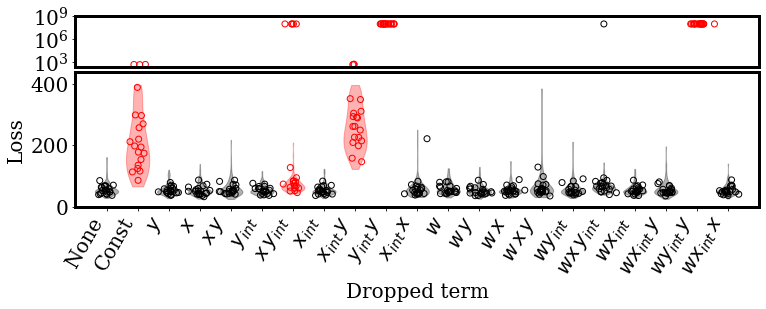

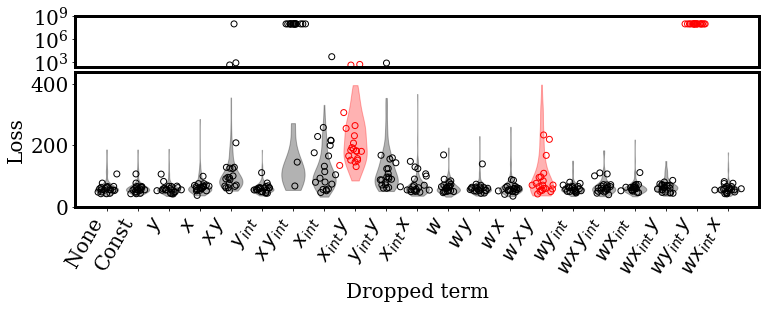

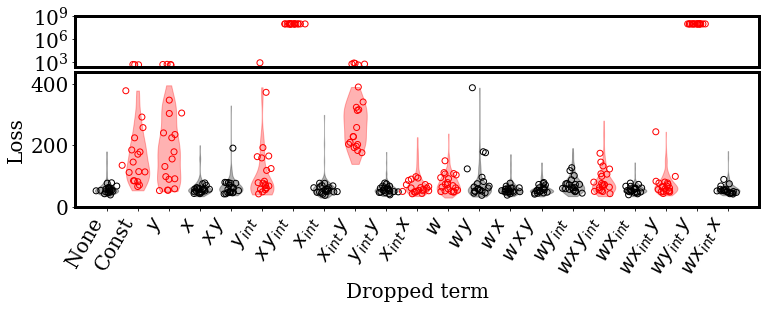

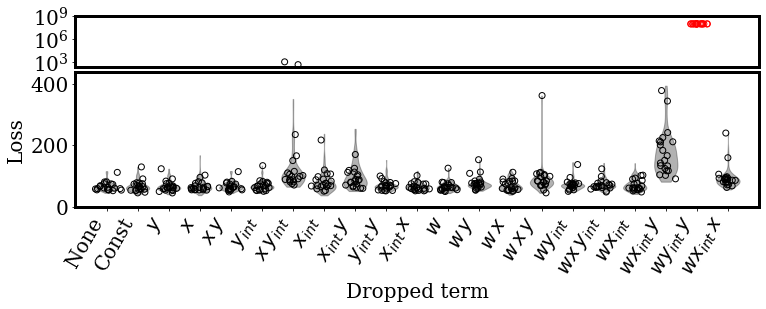

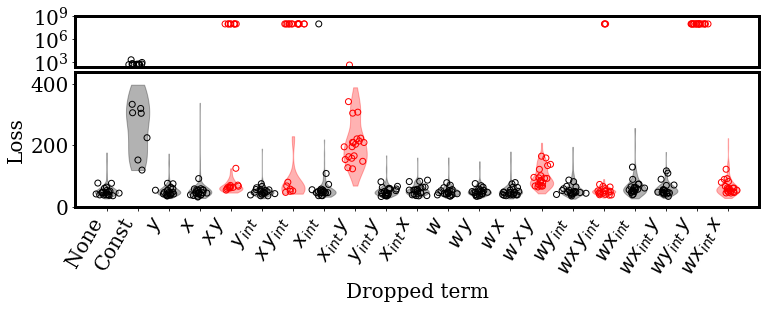

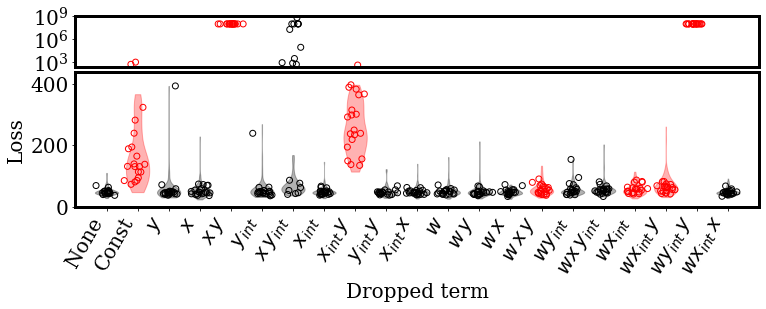

In [61]:
file_names = [
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:15:00.155072',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:00.379851',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:01.105619',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_12:07:49.829874',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:05:26.635227',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:06:31.988292',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:21:43.374771',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:22:54.088043',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:40:35.828201',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:51:46.367655',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:14:41.715701',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:16:41.213984',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:26:42.131598',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:28:16.398399',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:49:55.102012',
]
loss_violin_plots(file_names, 20, 12, 1, 100, n_categories=1, downsample_ratio=0.2)

# Ordering terms by KL divergence between dropped term case and null case

Here, we use the KL divergence between the dropout test cases and the no-dropout case to determine a heirarchy of term importance. 

In [168]:
def compute_kl_divs(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False, start=1)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
    
    max_loss, min_loss = (2e8, 0)
    bins = np.power(1.2, np.arange(100))
    bins = (max_loss - min_loss) * (bins - bins.min()) / (bins - bins.min()).max() + min_loss
    
    null_dist, _ = np.histogram(all_losses_for_dropouts[0, :], bins=bins, density=True)
    
    kl_divs = []

    epsilon = 1e-10    
    
    for d_idx in np.arange(1, all_losses_for_dropouts.shape[0]):
        term_dropped_dist, _ = np.histogram(all_losses_for_dropouts[d_idx, :], bins=bins, density=True)
        
        if np.isnan(term_dropped_dist).any():
            print(term_dropped_dist)
            print(all_losses_for_dropouts[d_idx, :])
        
        kl_divergence = np.sum((null_dist + epsilon) * np.log((null_dist + epsilon) / (term_dropped_dist + epsilon)))
        
        kl_divs.append(kl_divergence)
        
    return np.array(kl_divs), np.mean(all_losses_for_dropouts[0])
        

12
[0.47362641 0.04983829 0.02040231 0.62202924 0.03646543 0.84076503
 0.04523527 1.52885974 0.41198427 0.11538982 0.1159965  0.01835461
 0.02059986 0.14320249 0.10034984 0.04715501 0.05479412 0.22618974
 1.87868554 0.37048048]


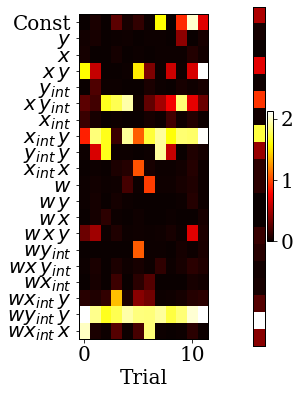

In [169]:
file_names = [
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:15:00.155072',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:00.379851',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:01.105619',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_12:07:49.829874',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:05:26.635227',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:06:31.988292',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:21:43.374771',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:22:54.088043',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:40:35.828201',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:51:46.367655',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:14:41.715701',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:16:41.213984',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:26:42.131598',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:28:16.398399',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:49:55.102012',
]

plt.rcParams['axes.linewidth'] = 1

all_kl_divs = []
for file_name in file_names:
    kl_divs, mean_non_dropped_loss = compute_kl_divs(file_name, 20, 12, 1, 100, n_categories=1)
    if mean_non_dropped_loss < 70:
#         print(kl_divs)
        all_kl_divs.append(kl_divs)

print(len(all_kl_divs))
all_kl_divs = np.array(all_kl_divs)
# all_kl_divs = np.concatenate([all_kl_divs, all_kl_divs.mean(axis=0).reshape(1, all_kl_divs.shape[1])])

scale = 3
gs = gridspec.GridSpec(1, 10)
fig = plt.figure(figsize=(1.5 * scale, 2 * scale), tight_layout=False)
axs = [fig.add_subplot(gs[:7]), fig.add_subplot(gs[7:])]

cbar = axs[0].imshow(all_kl_divs.T, aspect=1.5, cmap='hot')

print(np.mean(all_kl_divs.T, axis=1))
axs[1].imshow(np.mean(all_kl_divs.T, axis=1).reshape(all_kl_divs.shape[1], 1), aspect=1.5, cmap='hot')

fig.colorbar(cbar, ax=axs[1])


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,  # labels along the bottom edge are off
    labeltop=False)

# plt.tick_params(
#     axis='y',          # changes apply to the y-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False, # labels along the bottom edge are off
#     labeltop=False)

# axs.set_xticks([])
# axs.set_xticklabels([])
axs[0].set_yticks(np.arange(all_kl_divs.shape[1]))
axs[0].set_yticklabels(general_rule_names[:all_kl_divs.shape[1] + 1], rotation=0, ha='right')
axs[0].set_xlabel('Trial')
axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks([])
axs[1].set_yticklabels([])

fig.savefig('./figures/decoder_ee_unperturbed_kl_div_loss.png')
fig.savefig('./figures/decoder_ee_unperturbed_kl_div_loss.svg')

In [4]:
def compute_loss_shifts(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False, start=1)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_dropouts = np.array([losses[i:i + runs] for i in range(0, (n_plasticity_coefs + 1) * runs, runs)])
    
    kl_divs = []
    for d_idx in np.arange(1, all_losses_for_dropouts.shape[0]):
        kl_divergence = np.maximum(np.median(all_losses_for_dropouts[d_idx, :]) - np.median(all_losses_for_dropouts[0, :]), 0)
        kl_divs.append(kl_divergence)
        
    return np.array(kl_divs), np.mean(all_losses_for_dropouts[0])

12
[7.77074700e+01 1.17084868e+01 4.74018986e-01 3.37244537e+07
 7.46068701e+00 5.07580094e+07 8.59759982e+00 2.01954922e+02
 8.39936471e+06 1.93598291e+01 1.87472322e+01 6.21179954e-01
 7.43899633e-01 1.13759520e+01 8.44230923e+06 5.48768585e+00
 3.05669692e+00 2.23557725e+01 1.01357935e+08 1.69072495e+07]


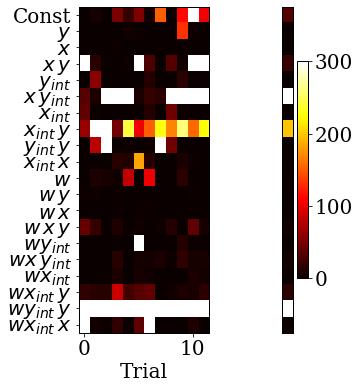

In [12]:
file_names = [
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:15:00.155072',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:00.379851',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_10:17:01.105619',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-08-31_12:07:49.829874',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:05:26.635227',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:06:31.988292',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:21:43.374771',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:22:54.088043',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:40:35.828201',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_15:51:46.367655',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:14:41.715701',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:16:41.213984',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:26:42.131598',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:28:16.398399',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-12-14_16:49:55.102012',
]

plt.rcParams['axes.linewidth'] = 1

all_kl_divs = []
for file_name in file_names:
    kl_divs, mean_non_dropped_loss = compute_loss_shifts(file_name, 20, 12, 1, 100, n_categories=1)
    if mean_non_dropped_loss < 70:
#         print(kl_divs)
        all_kl_divs.append(kl_divs)

print(len(all_kl_divs))
all_kl_divs = np.array(all_kl_divs)
# all_kl_divs = np.concatenate([all_kl_divs, all_kl_divs.mean(axis=0).reshape(1, all_kl_divs.shape[1])])

scale = 3
gs = gridspec.GridSpec(1, 10)
fig = plt.figure(figsize=(1.5 * scale, 2 * scale), tight_layout=False)
axs = [fig.add_subplot(gs[:7]), fig.add_subplot(gs[7:])]

cbar = axs[0].imshow(all_kl_divs.T, aspect=1.5, cmap='hot', vmax=300)

print(np.mean(all_kl_divs.T, axis=1))
axs[1].imshow(np.median(all_kl_divs.T, axis=1).reshape(all_kl_divs.shape[1], 1), aspect=1.5, cmap='hot', vmax=300)

fig.colorbar(cbar, ax=axs[1])


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,  # labels along the bottom edge are off
    labeltop=False)

# plt.tick_params(
#     axis='y',          # changes apply to the y-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False, # labels along the bottom edge are off
#     labeltop=False)

# axs.set_xticks([])
# axs.set_xticklabels([])
axs[0].set_yticks(np.arange(all_kl_divs.shape[1]))
axs[0].set_yticklabels(general_rule_names[:all_kl_divs.shape[1] + 1], rotation=0, ha='right')
axs[0].set_xlabel('Trial')
axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks([])
axs[1].set_yticklabels([])

fig.savefig('./figures/decoder_ee_unperturbed_median_loss.png')
fig.savefig('./figures/decoder_ee_unperturbed_median_loss.svg')

## What do the dynamics and weights look like?

In [41]:
def graph_perturbation_traj_fig(dir_path, n_e=25, n_i=8):
    
    T = 0.11 # Total duration of one network simulation
    dt = 1e-4 # Timestep
    t = np.linspace(0, T, int(T / dt))
        
    weights_path = os.path.join('./sims_out', dir_path, 'weights', '*')
    dynamics_path = os.path.join('./sims_out', dir_path, 'dynamics', '*')
    figure_path = f'./figures/{dir_path}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    last_batch_idx = None
    activation_ctr = 0
    
    cached_weights_exc = []
    cached_weights_rec = []
    cached_dynamics = []
    
    n_to_show = int(n_e * 0.6)
    to_show_mask = np.concatenate([np.ones(n_to_show), np.zeros(n_e - n_to_show)]).astype(bool)
    np.random.shuffle(to_show_mask)

    for i, (weights_path_i, dynamics_path_i) in enumerate(zip(reversed(sorted(glob.glob(weights_path))), reversed(sorted(glob.glob(dynamics_path))))):
        batch_idx_loc = weights_path_i.find('batch')
        batch_idx = int(weights_path_i[batch_idx_loc + 6:batch_idx_loc + 8])
        
        activation_idx_loc = weights_path_i.find('activ')
        activation_idx = int(weights_path_i[activation_idx_loc + 6:activation_idx_loc + 9])
        
        layer_colors = ['orange', '#078bf7', '#0fbd2f']
        
        
        if last_batch_idx is None or last_batch_idx != batch_idx:
            if last_batch_idx is not None:
                print(last_batch_idx)
                fig_w.tight_layout()
                fig.savefig(os.path.join(figure_path, f'dynamics_{last_batch_idx}.png'))
                fig.savefig(os.path.join(figure_path, f'dynamics_{last_batch_idx}.svg'))
                fig_w.savefig(os.path.join(figure_path, f'weights_{last_batch_idx}.png'))
                fig_w.savefig(os.path.join(figure_path, f'weights_{last_batch_idx}.svg'))
            
            activation_ctr = 0
            last_batch_idx = batch_idx
            cached_weights_exc = []
            cached_weights_rec = []
        
            scale = 1.5
            fig, axs = plt.subplots(1, 3, figsize=(6 * scale, 6 * scale), sharex=True, sharey=True)
            axs[0].set_yticks(np.arange(n_e))
            axs[0].set_yticklabels(np.arange(n_e))
            
            fig_w, axs_w = plt.subplots(1, 2, figsize=(5 * scale, 3 * scale), sharex=True, sharey=True)
            
#             axs_w.set_ylim(0)
#             axs_w_i.set_ylim(0)
        
        r = read_csv(dynamics_path_i, read_header=False, delimiter=',', start=0)
        r = np.array(r)
        
        if activation_ctr == 0:
            r_exc = r[:, :n_e]
            r_summed = np.sum(r_exc, axis=0)
            r_active_mask =  np.where(r_summed != 0, 1, 0).astype(bool)
            r_summed_safe_divide = np.where(r_active_mask, r_summed, 1)
            r_normed = r_exc / r_summed_safe_divide
            t_means = np.sum(t.reshape(t.shape[0], 1) * r_normed, axis=0)
            t_ordering = np.argsort(t_means)
            t_ordering = np.concatenate([t_ordering, np.arange(n_e, n_e + n_i)])
            
        if activation_ctr < 3:
            activation_ctr += 1
            continue

        r = r[:, t_ordering]
        
        n_shown = 0
        
        for cell_idx in range(n_e):
            if not to_show_mask[cell_idx]:
                continue
            
            r_idx = r[:, cell_idx]
            
            r_idx_active = copy(r_idx)
            r_idx_inactive = copy(r_idx)
            r_idx_active[r_idx <= 1e-6] = None
            r_idx_inactive[r_idx > 1e-6] = None
            
            c = layer_colors[activation_ctr % len(layer_colors)]
            # 0.3 * cell_idx * np.ones_like(r_idx_active) + 0.05 * activation_ctr
            axs[2 - (int(activation_ctr/3) - 1)].fill_between(t * 1000, np.ones_like(t) * (0.35 * n_shown + 0.075 * (activation_ctr % 3)), r_idx_active + 0.35 * n_shown + 0.075 * (activation_ctr % 3), color=c, alpha=1, lw=2, zorder=3 - (activation_ctr % 3))
            axs[2 - (int(activation_ctr/3) - 1)].plot(t * 1000, r_idx_inactive + 0.35 * n_shown + 0.075 * (activation_ctr % 3), c=c, alpha=0.25, lw=2, zorder=3 - (activation_ctr % 3))
            
            n_shown += 1

            
        axs[0].set_xlim(0, 95)
        axs[0].set_yticks([])
        axs[0].set_yticklabels([])
        axs[0].set_ylabel('Cell index')
        axs[0].set_xlabel('Time (s)')

        w = read_csv(weights_path_i, read_header=False, delimiter=',', start=0)
        w = np.array(w)

        sorted_w = w[t_ordering, :][:, t_ordering]
        w_e_e = sorted_w[:n_e, :n_e]
        summed_e_inputs = np.sum(w_e_e, axis=1)
        
        w_i_e = sorted_w[:n_e, n_e:]
        w_e_i = sorted_w[n_e:, :n_e]
        
        w_rec = np.abs([np.dot(w_i_e[j, :], w_e_i[:, j]) for j in range(n_e)])
        
        if activation_ctr == 3 or activation_ctr == 9:
            vmax = np.max(np.abs(sorted_w))
            vmax = 3
            mappable = axs_w[1 - int(activation_ctr / 6)].matshow(sorted_w, cmap='seismic', vmin=-vmax, vmax=vmax)
            plt.colorbar(mappable, fraction=0.046, pad=0.04)
            

        activation_ctr += 1
        
    fig_w.tight_layout()
    fig.savefig(os.path.join(figure_path, f'dynamics_{last_batch_idx}.png'))
    fig.savefig(os.path.join(figure_path, f'dynamics_{last_batch_idx}.svg'))
    fig_w.savefig(os.path.join(figure_path, f'weights_{last_batch_idx}.png'))
    fig_w.savefig(os.path.join(figure_path, f'weights_{last_batch_idx}.svg'))

4
3
2
1


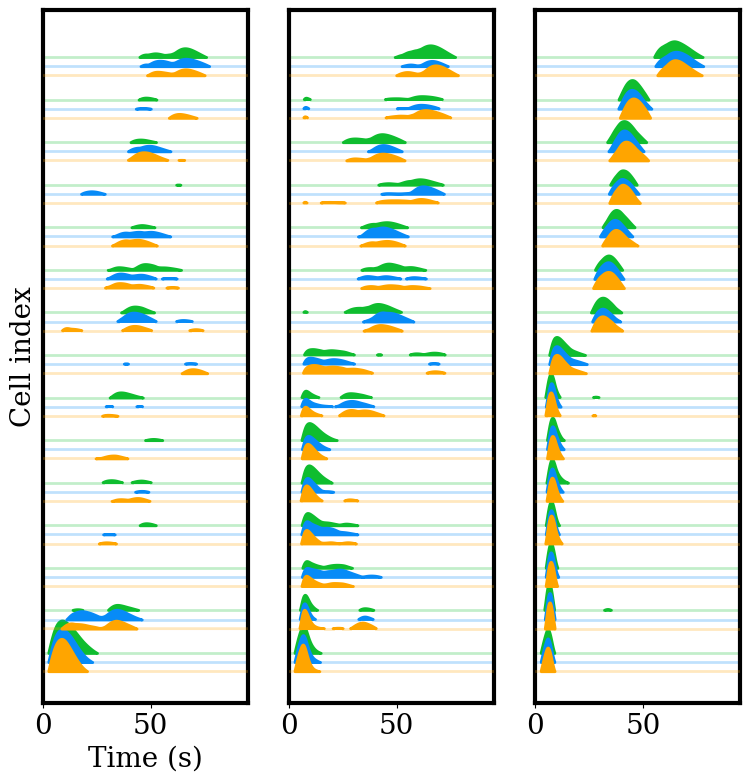

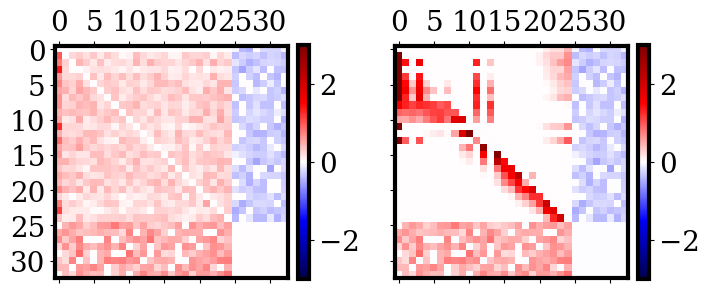

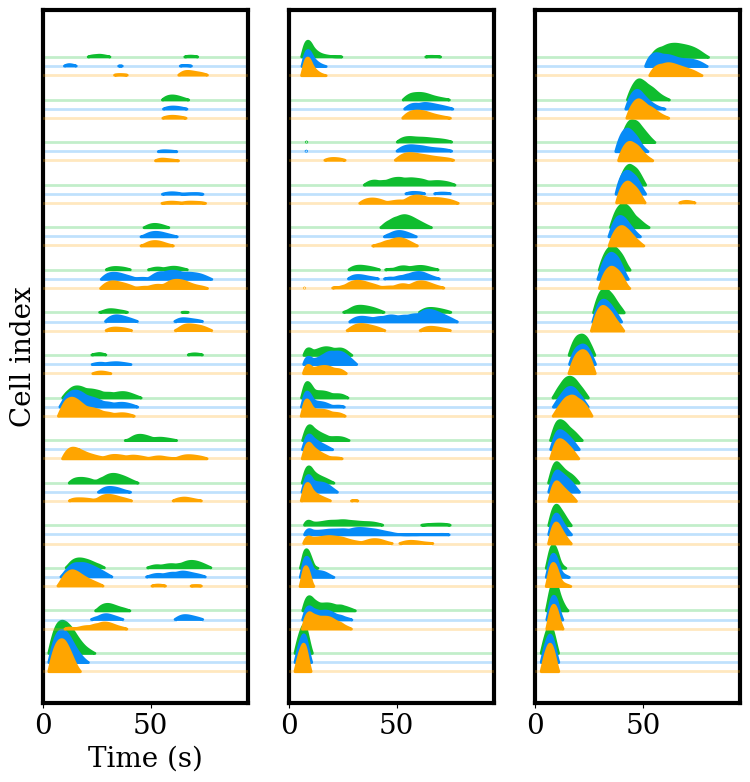

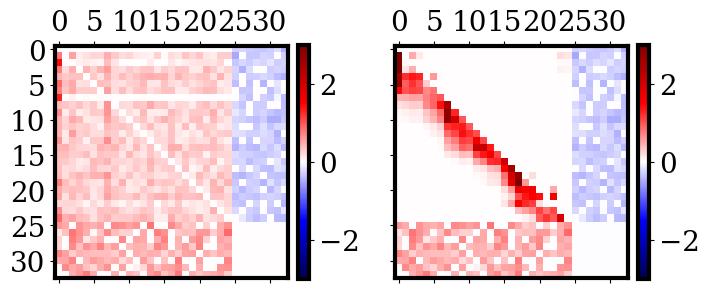

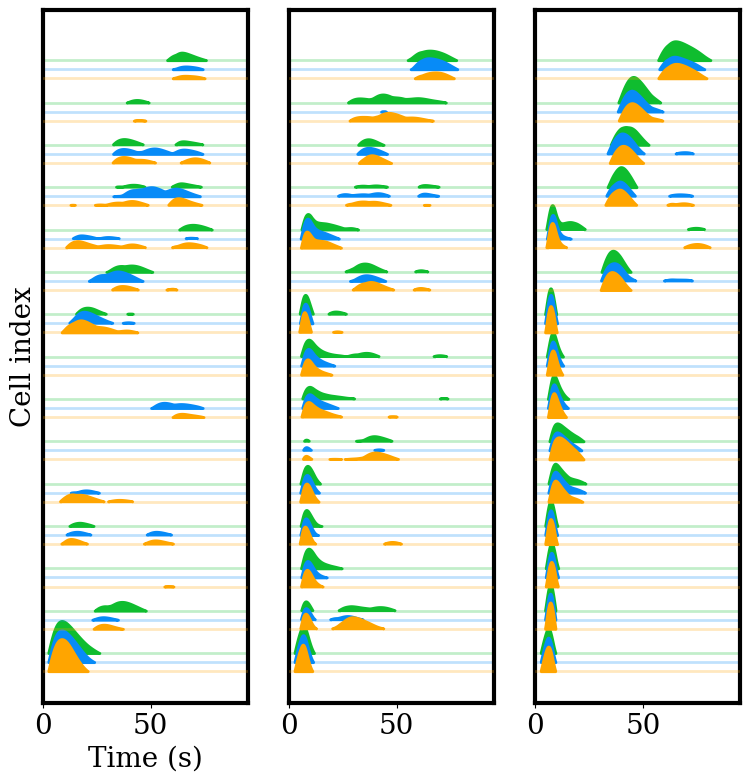

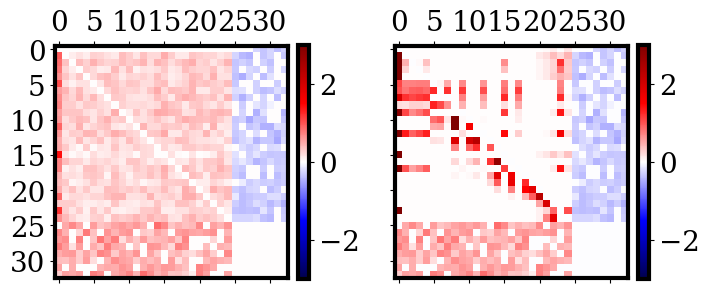

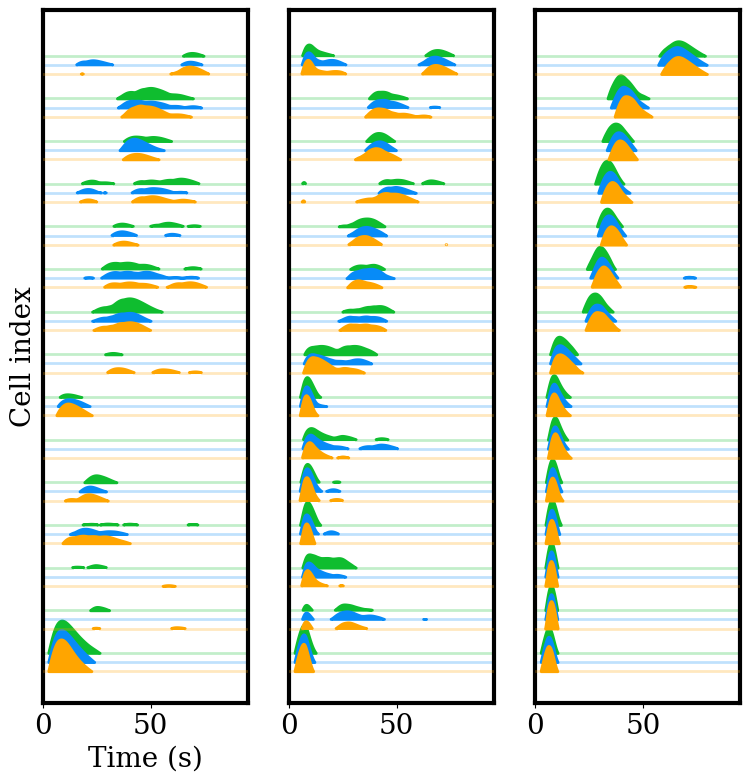

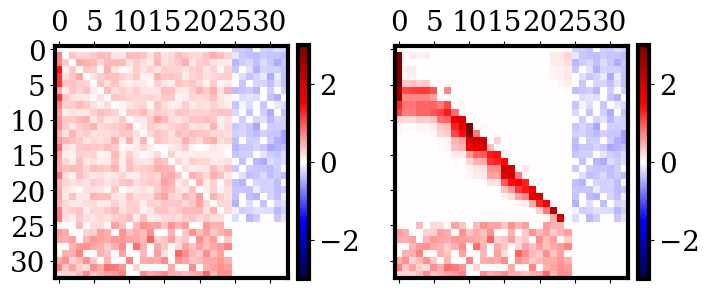

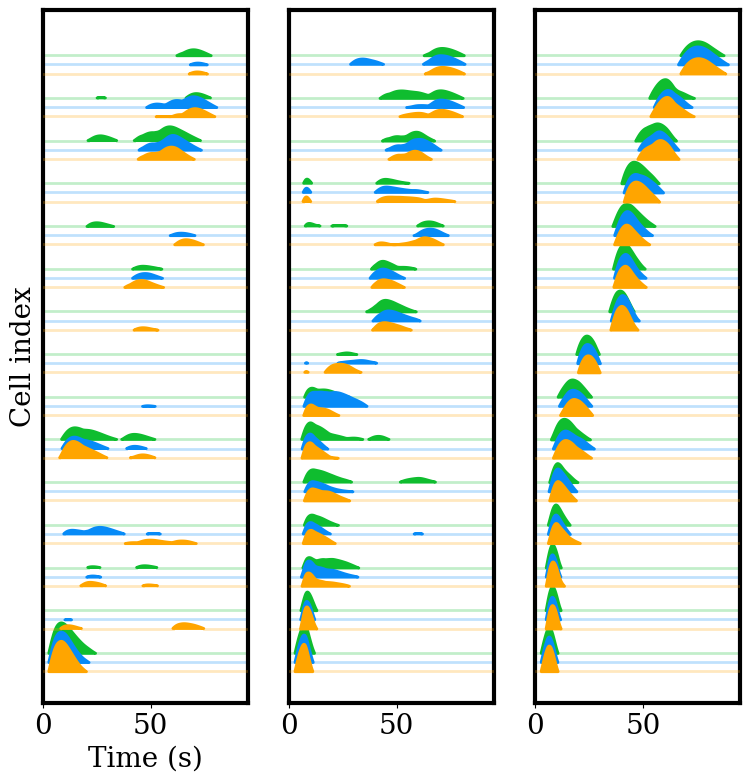

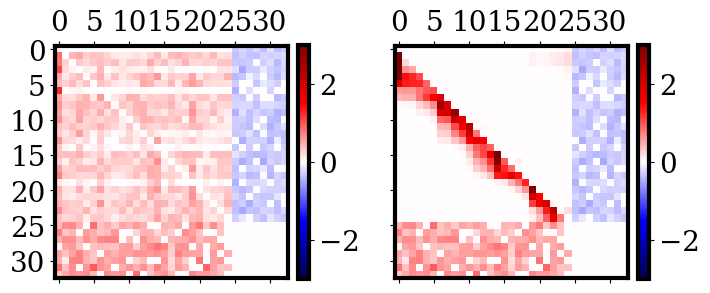

In [42]:
f_path = 'decoder_ee_test_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_1_2024-04-06_15:30:33.882749'
graph_perturbation_traj_fig(f_path, n_e=25, n_i=8)

# Building the model progressively to determine terms of true importance

Loss vs loss of full model

In [7]:
def fetch_minimum_loss(file_name, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    df_train = read_csv(train_data_path, read_header=False, start=1)
    df_test = read_csv(test_data_path, read_header=False, start=1)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    min_loss_idx = df_train[df_train.columns[0]][np.argmin(losses)]
    
    losses_test = df_test[df_test.columns[1]]
    
    return np.min(losses), np.min(losses_test)

Text(0.5, 0, 'No. terms included')

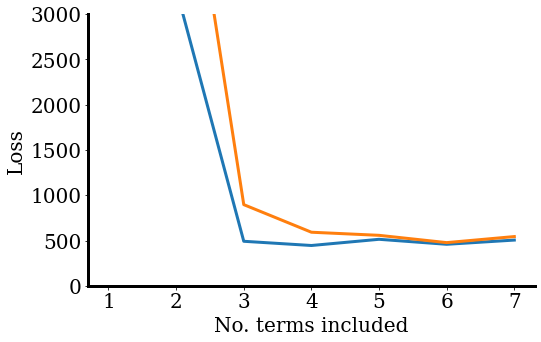

In [9]:
file_names = [
    'refit_ee_unpert_median_1_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_1000_2024-05-07_15:05:33.852452',
    'refit_ee_unpert_median_2_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_1000_2024-05-07_15:17:39.753406',
    'refit_ee_unpert_median_3_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_1000_2024-05-07_15:18:03.836551',
    'refit_ee_unpert_median_4_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_1000_2024-05-07_15:19:05.713924',
    'refit_ee_unpert_median_5_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_1000_2024-05-07_22:33:49.220093',
    'refit_ee_unpert_median_6_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_1000_2024-05-08_01:56:49.919144',
    'refit_ee_unpert_median_7_terms_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_CHANGEP_0.0_FRACI_0.75_SEED_1000_2024-05-08_01:57:28.941777',
]

all_losses = []
all_losses_test = []
for f in file_names:
    min_loss, min_loss_test = fetch_minimum_loss(f, 20, 12, 10)
    all_losses.append(min_loss)
    all_losses_test.append(min_loss_test)

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 2.5 * scale))
format_axs(axs)

axs.plot(np.arange(1, 8), all_losses, lw=3)
axs.plot(np.arange(1, 8), all_losses_test, lw=3)
# axs.set_yscale('log')
axs.set_ylim(0, 3000)
axs.set_ylabel('Loss')
axs.set_xlabel('No. terms included')

In [166]:
def plot_elbo_curve(file_name, n_plasticity_coefs, n_time_constants, batch_size, runs, n_categories=1, full_rules_file_name=None):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False, start=1)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_terms = np.array([losses[i:i + runs] for i in range(0,  len(losses), runs)])
    mean_losses_for_terms = np.array([np.mean(ls) for ls in all_losses_for_terms])
    std_losses_for_terms = np.array([np.std(ls) for ls in all_losses_for_terms])
    cis_for_terms = 1.96 * (std_losses_for_terms / np.sqrt(runs))
    
    cutoff = 500
    
    scale = 1.75
    gs = gridspec.GridSpec(5 * n_categories, 1)
    fig = plt.figure(figsize=(4.5 * scale, 3.3 * scale), tight_layout=True)
    axs = [fig.add_subplot(gs[:2]), fig.add_subplot(gs[2:5])]
    
    axs[1].set_ylabel('Loss')
    axs[0].set_xticks([])
    axs[0].set_xlim(0.5, 8)
    axs[0].set_xticklabels([])
    if full_rules_file_name is not None:
        axs[1].set_xticks(np.arange(9))
        axs[1].set_xticklabels(np.concatenate([np.arange(0, 8), ['All']]))
    else:
        axs[1].set_xticks(np.arange(8))
        axs[1].set_xticklabels(np.arange(0, 8))
    axs[1].set_xlabel('No. terms included')
    axs[1].set_xlim(0.5, 8)

    axs[0].set_yscale('log')
    axs[0].set_ylim(cutoff * 0.5, 1e9)
    axs[1].set_ylim(0, cutoff * 1.1)

    axs[0].spines['bottom'].set_visible(False)
#     axs[0].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
#     axs[1].spines['right'].set_visible(False)
    
    for term_idx in np.arange(all_losses_for_terms.shape[0]):
        
        mask_over_cutoff = all_losses_for_terms[term_idx] > cutoff
        
        if np.mean(all_losses_for_terms[term_idx]) > cutoff:
            axs[0].errorbar([term_idx + 1.5], [np.mean(all_losses_for_terms[term_idx])], yerr=np.std(all_losses_for_terms[term_idx]) / np.sqrt(100), color='black')
            axs[0].scatter([term_idx + 1.5], np.mean(all_losses_for_terms[term_idx]), color='black')
        
        axs[0].scatter(
            (runs * [term_idx + 1] + np.random.normal(size=runs, scale=0.1))[mask_over_cutoff],
            all_losses_for_terms[term_idx][mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='#076eb0',
            alpha=0.5,
            s=50, 
        )
        
        if np.mean(all_losses_for_terms[term_idx]) <= cutoff:
            axs[1].errorbar([term_idx + 1.5], [np.mean(all_losses_for_terms[term_idx])], yerr=np.std(all_losses_for_terms[term_idx]) / np.sqrt(100), color='black')
            axs[1].scatter([term_idx + 1.5], np.mean(all_losses_for_terms[term_idx]), color='black')
        
        axs[1].scatter(
            (runs * [term_idx + 1] + np.random.normal(size=runs, scale=0.1))[~mask_over_cutoff],
            all_losses_for_terms[term_idx][~mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='#076eb0',
            alpha=0.5,
            s=50,
        )
    
#     axs[1].set_yscale('log')
    
    if full_rules_file_name is not None:
        train_data_path_fm = f'./sims_out/{full_rules_file_name}/train_data.csv'
        df_train_fm = read_csv(train_data_path_fm, read_header=False, start=1)
        
        losses_fm = df_train_fm[df_train_fm.columns[1]][:runs]
        
        mask_over_cutoff = losses_fm > cutoff
        
        axs[0].scatter(
            (runs * [term_idx + 2] + np.random.normal(size=runs, scale=0.15))[mask_over_cutoff],
            losses_fm[mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='black',
            alpha=0.5,
        )
        
        axs[1].scatter(
            (runs * [term_idx + 2] + np.random.normal(size=runs, scale=0.15))[~mask_over_cutoff],
            losses_fm[~mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor='black',
            alpha=0.5,
        )
    
    set_font_size(axs[0], 20)
    set_font_size(axs[1], 20)
        
    fig.savefig(os.path.join(figure_path, 'refit_elbo_plot.png'))
    fig.savefig(os.path.join(figure_path, 'refit_elbo_plot.svg'))
        

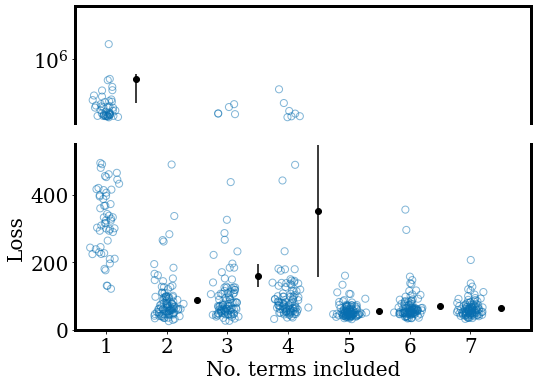

In [167]:
plot_elbo_curve(
    'decoder_ee_test_refit_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_2000_2024-04-15_15:22:19.518438',
    20,
    12,
    1,
    100,
    n_categories=1,
)

# What happens if synaptic turnover is introduced?

In [2]:
def plot_all_losses(file_names, n_plasticity_coefs, n_time_constants, batch_size, n_categories=1, colors=None, labels=None):
    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants
    
    cutoff = 400
    
    scale = 2
    gs = gridspec.GridSpec(5 * n_categories, 1)
    fig = plt.figure(figsize=(6 * scale, 3.5 * n_categories * scale), tight_layout=True)
    axs = [fig.add_subplot(gs[:2]), fig.add_subplot(gs[2:5])]
    
    axs[1].set_ylabel('Loss')
    axs[0].set_xticks([])
    axs[0].set_xlim(0, len(file_names) + 1)
    axs[0].set_xticklabels([])
#     axs[1].set_xticklabels(np.concatenate([np.arange(0, len(file_names)), ['All']]))
#     axs[1].set_xlabel('No. terms included')
    axs[1].set_xlim(0, len(file_names) + 1)

    axs[0].set_yscale('log')
    axs[0].set_ylim(cutoff * 0.5, 1e9)
    axs[1].set_ylim(0, cutoff * 1.1)
    if labels is None:
        labels = [''] + ['Summed\nsynaptic'] * 2 + ['Meta-learned'] * 2 + ['Meta-learned\nwith turnover'] * 2
    axs[1].set_xticklabels(labels, rotation=30)

    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    
    if colors is None:
        colors = ['black', 'green', 'black', 'green', 'black', 'green']
    
    for file_idx, file_name in enumerate(file_names): 
        train_data_path = f'./sims_out/{file_name}/train_data.csv'

        df_train = read_csv(train_data_path, read_header=False)
        
        losses = df_train[df_train.columns[1]]
        
        print(f'median: {np.median(losses)}, mean: {np.mean(losses)}')
        
        mask_over_cutoff = losses > cutoff
        
        axs[0].scatter(
            (len(losses) * [file_idx + 1] + np.random.normal(size=len(losses), scale=0.05))[mask_over_cutoff],
            losses[mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor=colors[file_idx],
            
        )
        
        axs[1].scatter(
            (len(losses) * [file_idx + 1] + np.random.normal(size=len(losses), scale=0.05))[~mask_over_cutoff],
            losses[~mask_over_cutoff],
            marker='o',
            facecolor='none',
            edgecolor=colors[file_idx],
              
        )
        
        
    set_font_size(axs[0], 22)
    set_font_size(axs[1], 22)
    fig.savefig('figures/stress_test_comp_ila.png')
    fig.savefig('figures/stress_test_comp_ila.svg')
    
        

In [ ]:
plot_all_losses([
    'ila_network_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:12:57.175017',
    'ila_network_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_14:13:35.002314',
    'stress_test_ee_unpert_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_10:53:02.459275',
    'stress_test_ee_unpert_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_10:54:41.632693',
    'stress_test_ee_pert_4_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_12:04:01.566259',
    'stress_test_ee_pert_4_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_700_2023-09-08_12:05:05.484616'
], 20, 12, 1, n_categories=1)

median: 110.03479371332295, mean: 133.05150089744728
median: 82.49475933540937, mean: 94.80764193912869
median: 143.20543400016717, mean: 162.13707453021755
median: 110.16290394861593, mean: 137.3703335743737


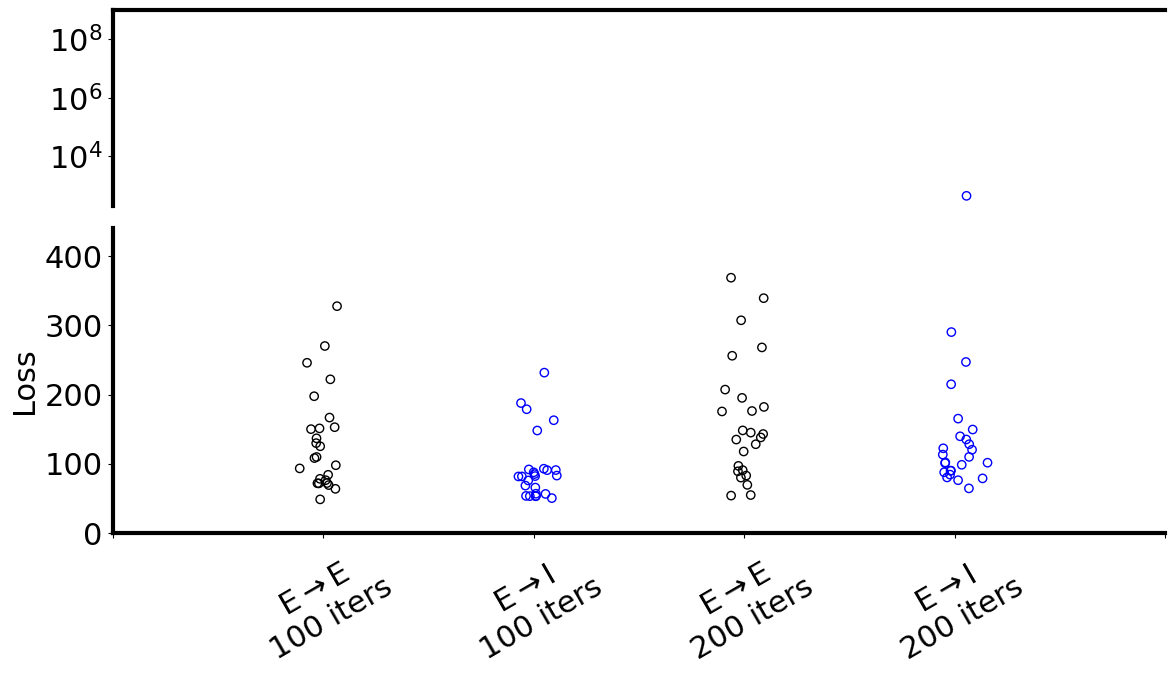

In [6]:
plot_all_losses([
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-12-27_23:15:25.072344',
    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-12-27_19:22:27.113650',
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-12-28_12:48:32.064038',
    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_500_2023-12-28_13:11:46.245452',
], 20, 12, 1, n_categories=1,
colors=['black', 'blue', 'black', 'blue'],
labels=[
    '',
    r'E$\rightarrow$E' + '\n100 iters',
    r'E$\rightarrow$I' + '\n100 iters',
    r'E$\rightarrow$E' + '\n200 iters',
    r'E$\rightarrow$I' + '\n200 iters'
])

median: 128.69384214368, mean: 244.91600695659702
median: 71.82584385859506, mean: 99.93177641387567


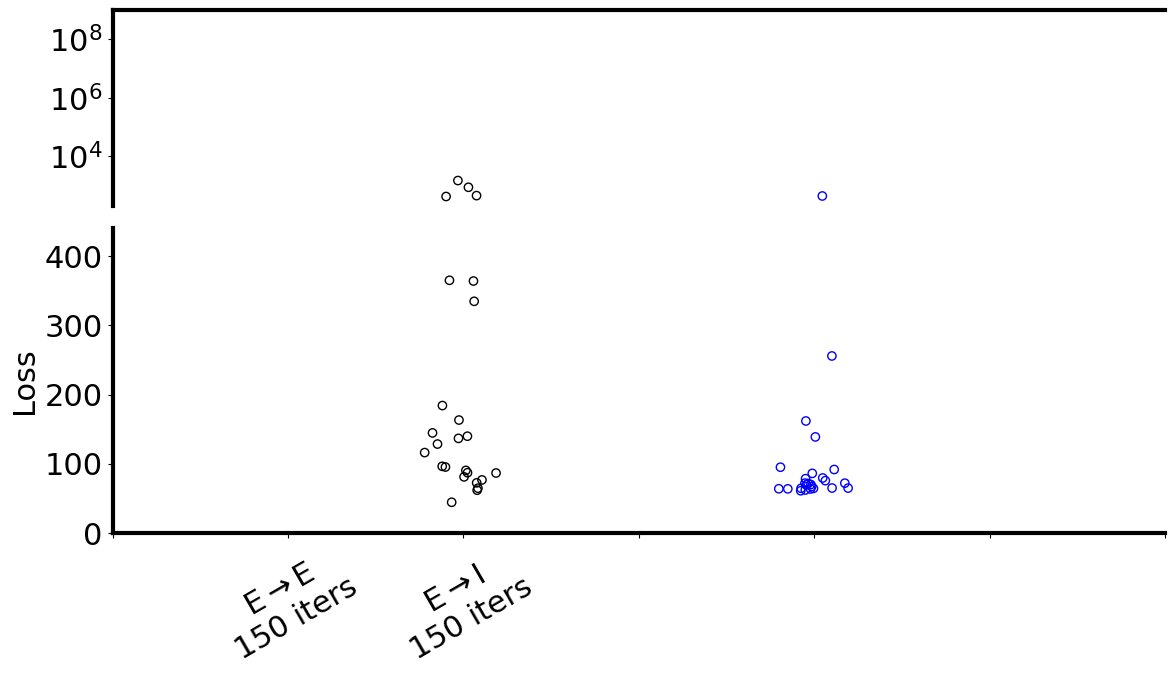

In [7]:
plot_all_losses([
    'decoder_ee_rollback_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_502_2023-12-28_14:46:45.499087',
    'stress_test_ei_decoder_none_dropped_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.00072_FRACI_0.75_SEED_502_2023-12-28_15:06:01.964623',
], 20, 12, 1, n_categories=1,
colors=['black', 'blue', 'black', 'blue'],
labels=[
    '',
    r'E$\rightarrow$E' + '\n150 iters',
    r'E$\rightarrow$I' + '\n150 iters',
])

92.26789448097274
105.68200186975604
148.33032153710997
211.0335113479535


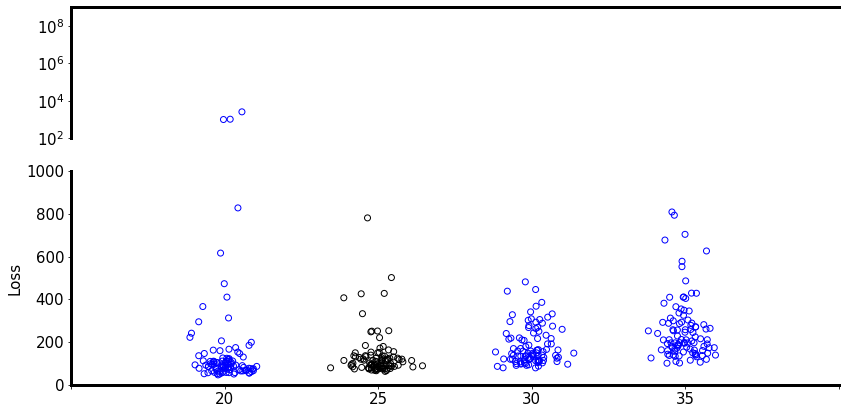

In [49]:
plot_all_losses([
    'stress_test_ee_unpert_20_cell_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:22:32.863267',
    'stress_test_ee_unpert_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_10:53:02.459275',
    'stress_test_ee_unpert_30_cell_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:24:03.527532',
    'stress_test_ee_unpert_35_cell_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_700_2023-09-08_14:36:38.242252',
], 20, 12, 1, n_categories=1, colors=['blue', 'black', 'blue', 'blue'], labels=['', '20', '25', '30', '35'])